<a href="https://colab.research.google.com/github/aubreethomp/Stock-Prediction-Models/blob/main/cm332_project_g2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CM332 Data Mining Project
## Title: **TODO: Stock Market Prediction**
### Team Members: **TODO: Anna and Aubree**

## Abstract:

**TODO: Write abstract here (200-400 words). Describe the purpose of the project you're analyzing, the specific research question you seek to validate including the original paper's conclusion, the nature and source of the data you'll use, the methodology you plan to apply, and the expected results.**

The purpose of the original project was to create a model to predict stock prices. Another goal of the original paper was to determine which models would work the best in different sectors. The original paper discussed the creation of six models to predict stock price. The paper focused on three sectors: IT, Banking, and Health. Their data was collected from Yahoo finance. The original paper concluded that the best time series and economic model was ARIMA, the best machine learning model was MARS, and the best deep learning model was LSTM. They determined which model was the best by looking at the Root Mean Square Error, RMSE for short, divided by the mean of close values. We aim to recreate the original models and validate the results concerning the effectiveness of the models. The training data is from 2004 to 2018. We plan to extend the model to account for the impact of COVID. We will do this by including data from 2019 to 2023. We will use data web scraped from NASDAQ, containing historical stock market values from the top 10 most popular stocks (most likely will not use all of these stocks); this data set contains values from 2013 to 2023. We expect that the models trained on the original 2004 to 2018 data will not accurately predict the stock values due to the unexpected changes in the stock market brought on by COVID. Causing potenially different results from the original paper. Original research: https://arxiv.org/pdf/2111.01137

## Setup

In [ ]:
# Setup
# TODO: load libraries and other utilities you'll use throughout your notebook here

!pip install pmdarima
!pip install pyearth
!pip install keras
!pip install tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import pyearth as py
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import pmdarima as pm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.0/170.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 17.5 MB/s eta 0:00:00


## Data Set / Aquisition

**TODO: (200-500 words) describe your dataset including important details such as provenance, authenticity, why it was collected, etc. Describe the format of the data and what attributes are present including thier purpose and datatypes. Include any other information we should know about the data.**

The primary motivation behind collecting this dataset is to enable researchers and analysts to explore and develop predictive models for stock price movements. By focusing on the top-performing companies, the dataset provides a robust foundation for examining market trends, volatility, and the interplay of various financial indicators. This aligns with the objectives of our project, which aims to validate and extend existing research concerning the effectiveness of stock price forecasting models. The data was web-scraped from NASDAQ, a reliable source for stock information. It contains historical stock data from the top ten stocks from 2013-2023; this gives us a good amount of data to train and test with. The attributes are volume, close/last, company, date, open, high, and low. "Company" refers to the company the data was collected from. "Date" refers to the date the data was collected. "Open" refers to the opening price of the stock. "Close/last" refers to the closing price of the stock. "High" refers to the maximum price of the stock that day. "Low" refers to the minimum price of the stock that day. "Volume" refers to the amount that stock that was exchanged that day. The "volume" variable is currently stored as an integer. The remaining columns (company, date, close/last, open, high, and low) are currently stored as general objects. We will edit some of these to make the data easier to work with.

In [ ]:
# Load Data
# TODO: load data from external, public source


!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mkdir -p ./stock_data
!kaggle datasets download khushipitroda/stock-market-historical-data-of-top-10-companies -p ./stock_data
!unzip ./stock_data/stock-market-historical-data-of-top-10-companies.zip -d ./stock_data

df=pd.read_csv('./stock_data/data.csv')
print(df.head())




cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/khushipitroda/stock-market-historical-data-of-top-10-companies
License(s): other
  0% 0.00/476k [00:00<?, ?B/s]
100% 476k/476k [00:00<00:00, 61.7MB/s]
Archive:  ./stock_data/stock-market-historical-data-of-top-10-companies.zip
  inflating: ./stock_data/data.csv   
  Company        Date Close/Last    Volume     Open       High      Low
0    AAPL  07/17/2023    $193.99  50520160  $191.90    $194.32  $191.81
1    AAPL  07/14/2023    $190.69  41616240  $190.23  $191.1799  $189.63
2    AAPL  07/13/2023    $190.54  41342340  $190.50    $191.19  $189.78
3    AAPL  07-12-2023    $189.77  60750250  $189.68    $191.70  $188.47
4    AAPL  07-11-2023    $188.08  46638120  $189.16    $189.30  $186.60


In [ ]:
df.dtypes

,0
Company,object
Date,object
Close/Last,object
Volume,int64
Open,object
High,object
Low,object


## Exploratory Analysis / Visualization

**TODO: (300-600 words) Explain what you're looking for in the data to help you understand how to use it to answer your question or otherwise meet your project goals. Next, explain the relevance to the original study -- are you validating their exploratory analysis, building on it, or trying something different? Then, explain what steps you took to explore the dataset, including code that implements these explorations. Finally, comment on the results of your exploration and identify how it shaped the latter steps of your project. If you feel you have a better visiualization of your results than an exploratory visualization, you may implement this section at the end instead of or in addition to this section here. You may want to use additional text and code cells to intersperse elements of your report with code that computes supporting statistics and visualizations.**

We are aiming to validate the results of the original study by comparing the effectiveness of different models for stock price prediction. The original study focused on predicting the closing price of the stocks. We are also going to build on this by including data from COVID into the train data set to show how accurately the models can predict changes after the effectsof external sources. We will visualize the historical trends of the top ten stocks and choose three stocks to focus on. We want to choose three that accurately represent the effects of COVID and are visually different from each other. Furthermore, we will visualize trends in the data to decide where the cutoff should be between training and test data. We will do an around a 4:1 ratio for training and test data (will be adjusted as necessary). Data visualization will be more prominent at the end of our project because we will graph the models' predictions in comparison to the actual stock values.



Summary Statistics:
                                Date    Close/Last        Volume  \
count                          25160  25160.000000  2.516000e+04   
mean   2018-07-15 16:11:49.697933056    102.455878  5.131764e+07   
min              2013-07-18 00:00:00      1.620000  1.143952e+06   
25%              2016-01-14 18:00:00     36.567500  1.200394e+07   
50%              2018-07-16 12:00:00     65.680000  2.672083e+07   
75%              2021-01-13 06:00:00    134.235025  6.857269e+07   
max              2023-07-17 00:00:00    691.690000  1.065209e+09   
std                              NaN    101.991372  6.399143e+07   

               Open          High           Low  
count  25160.000000  25160.000000  25160.000000  
mean     102.430761    103.829305    101.006112  
min        1.620000      1.690000      1.610000  
25%       36.507500     36.890000     36.128000  
50%       65.650000     66.486900     64.915500  
75%      134.320000    136.233525    132.660000  
max      692.35

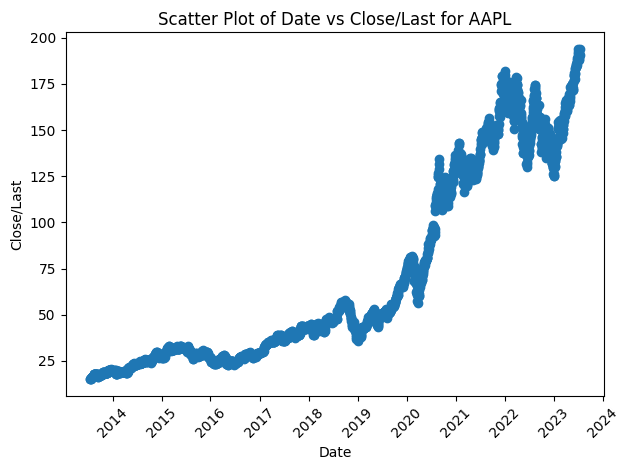

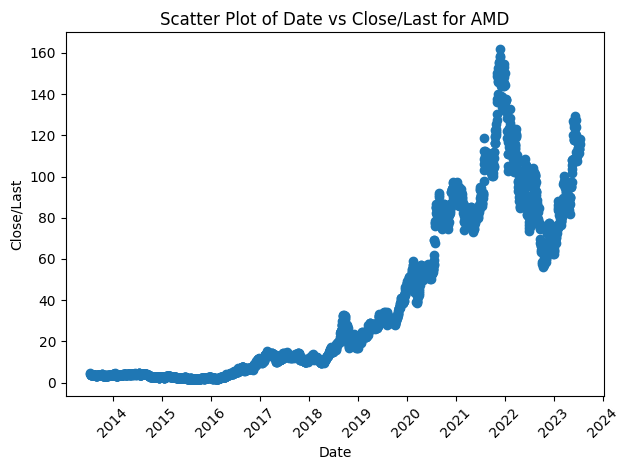

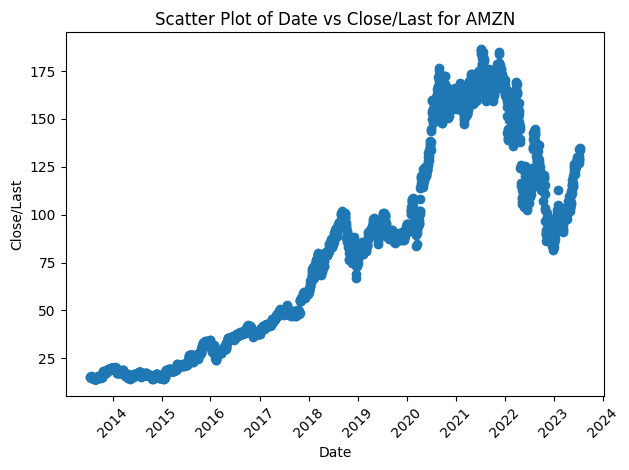

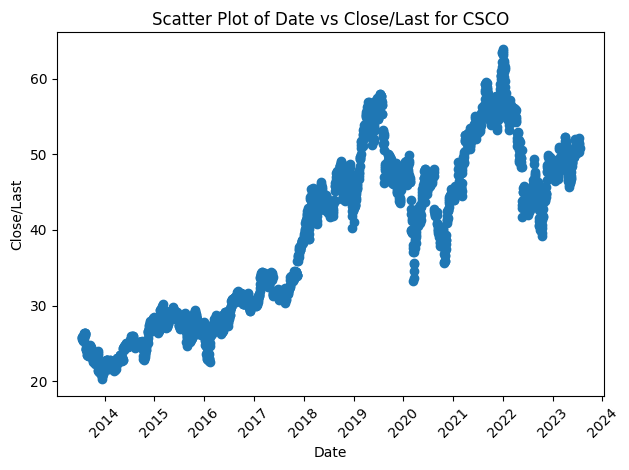

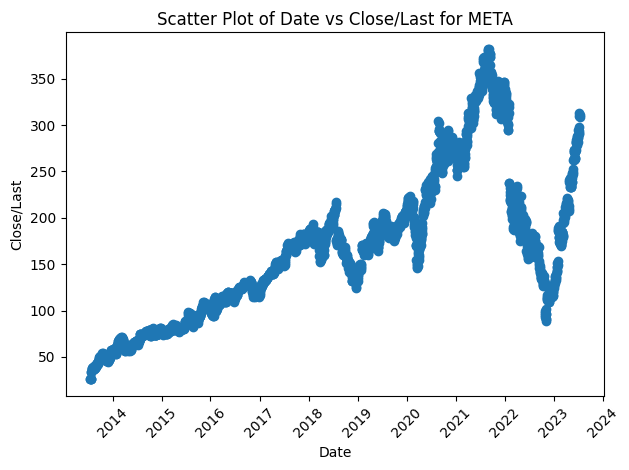

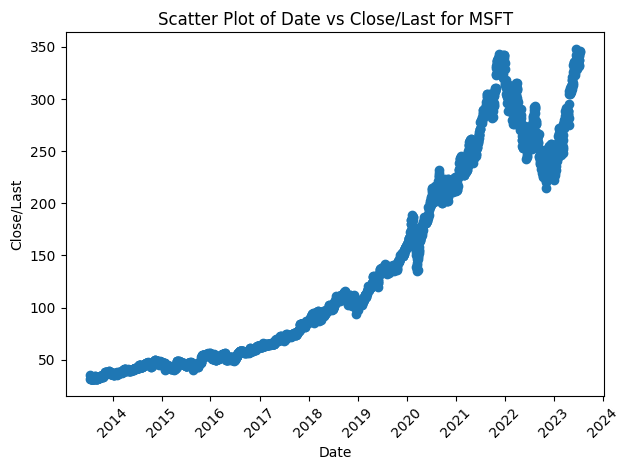

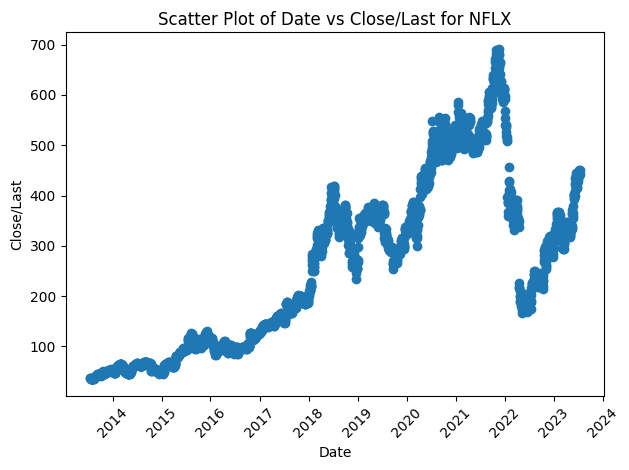

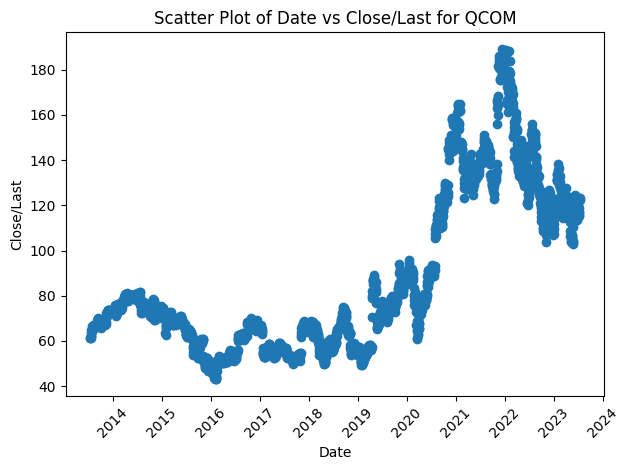

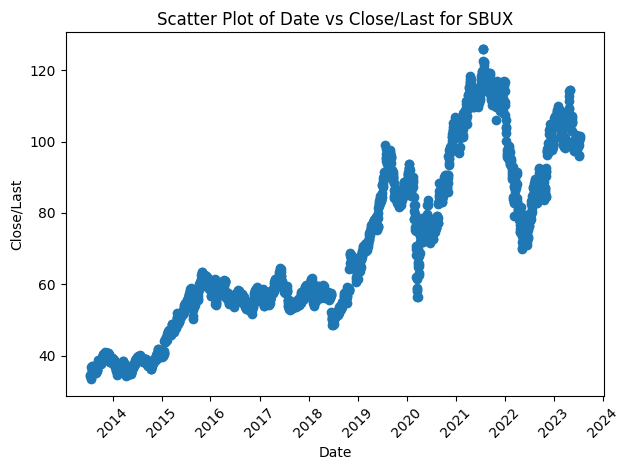

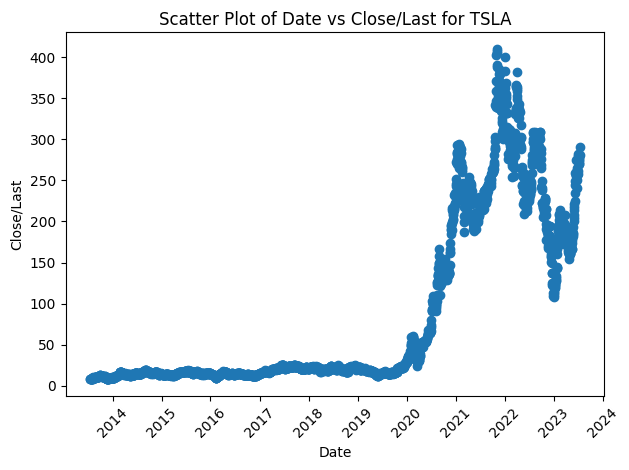

No duplicate entries found.


<ipython-input-3-b01ba9fb0f0c>:77: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.set_index('Date').groupby('Company').resample('M').mean().reset_index()


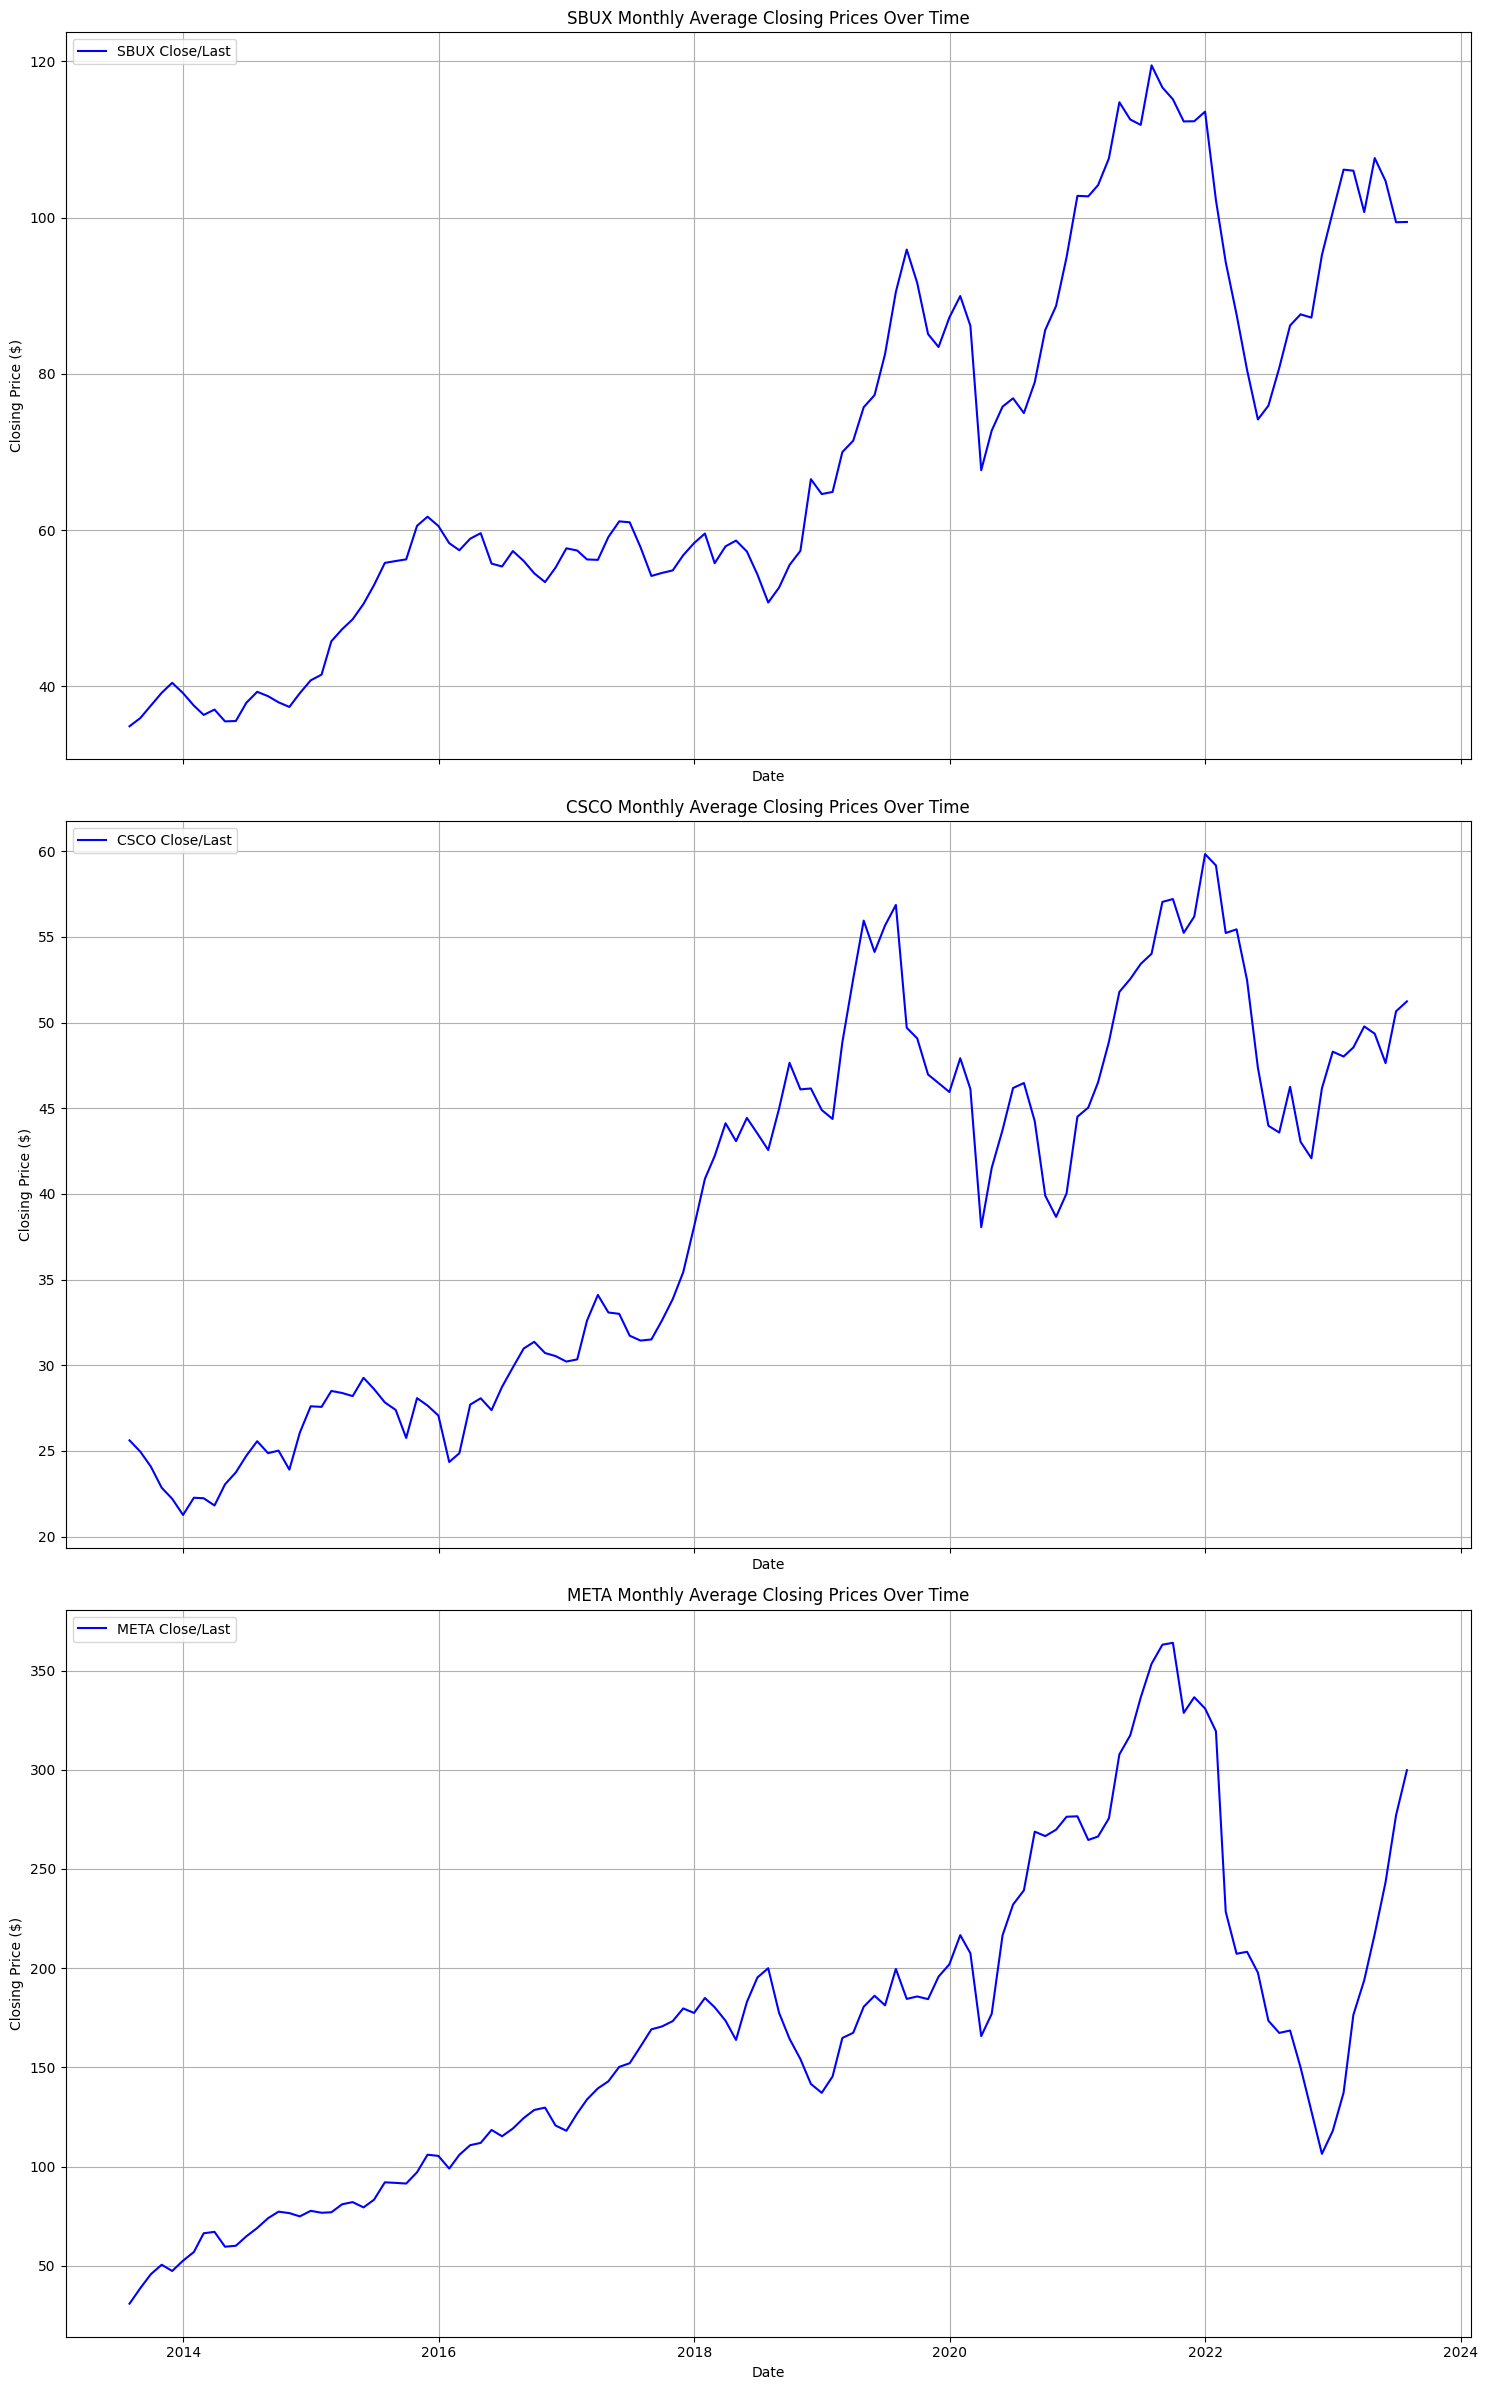

Training Set: 6642 records
Testing Set: 906 records


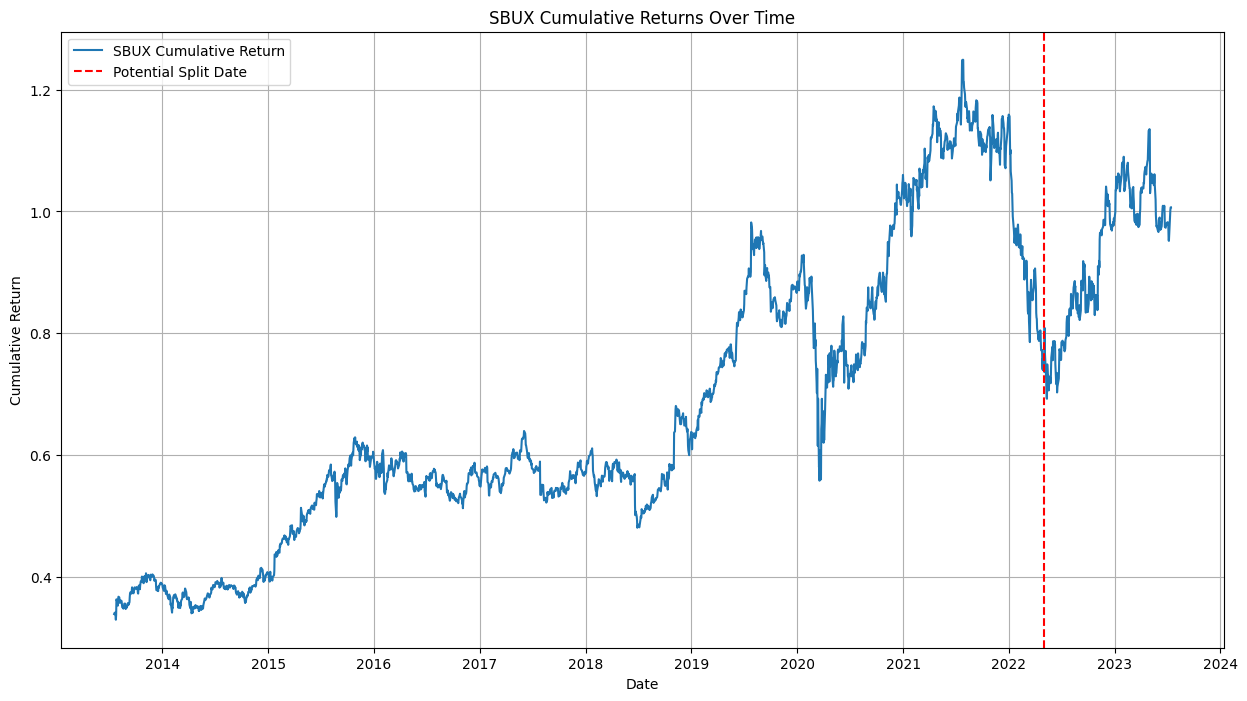

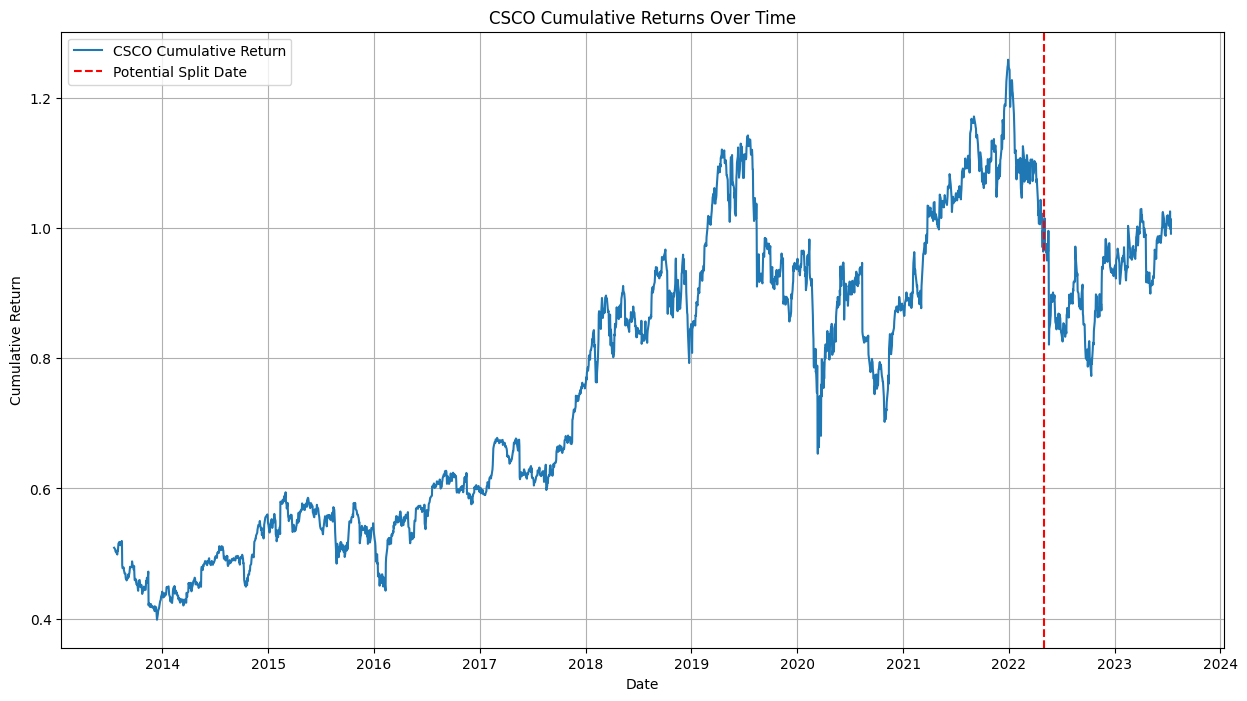

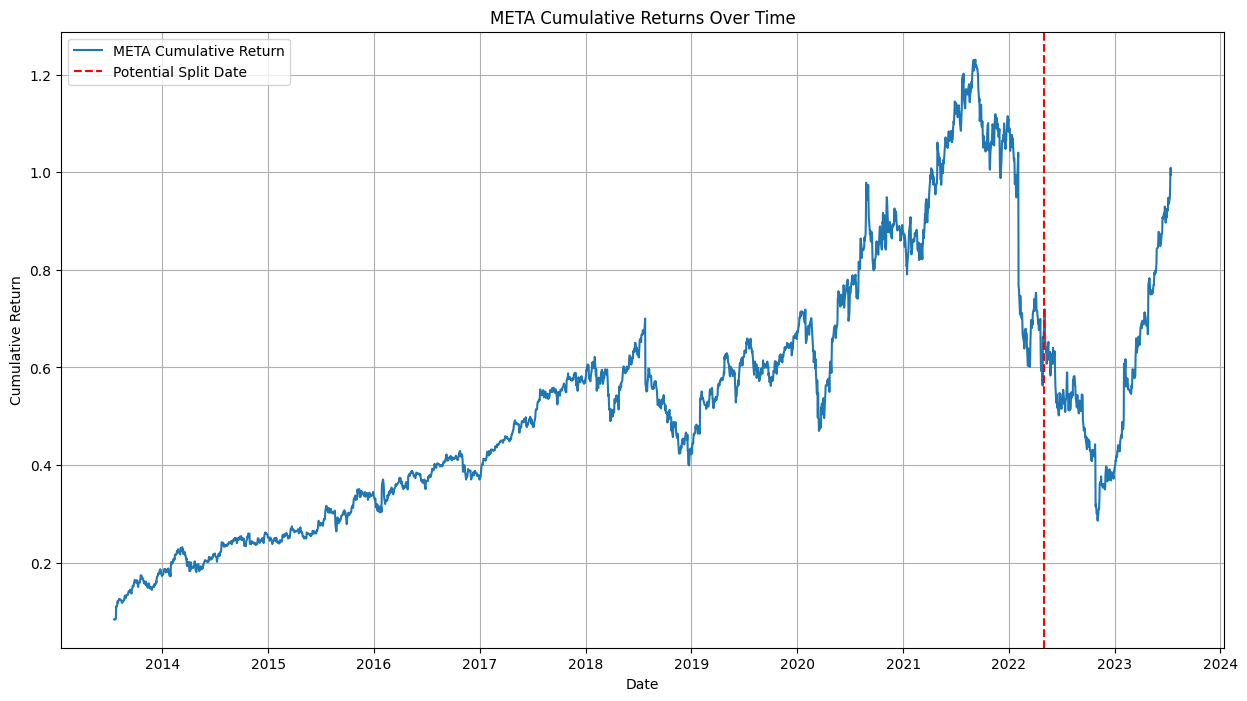

In [ ]:
# Analyze

# TODO: add code to perform exploratory analysis or visualize
# elements of your dataset.
#Visualize

#have to clean dates and currency values so we can use them as numerics to visualize the data
def clean_and_convert_date(df, date_column='Date'):
    """
    Cleans and converts the specified date column to datetime.
    Only applies string replacement if the column is of object type.
    """
    if df[date_column].dtype == 'object':
        # Replace '-' with '/' if present
        df[date_column] = df[date_column].str.replace('-', '/', regex=False)
        # Convert to datetime
        df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y', errors='coerce')
    elif pd.api.types.is_datetime64_any_dtype(df[date_column]):
        print(f"'{date_column}' column is already in datetime format. Skipping string replacement.")
    else:
        print(f"'{date_column}' column has an unsupported data type: {df[date_column].dtype}")
    return df
# Clean currency values by removing dollar signs and commas, then convert to float
currency_columns = ['Close/Last', 'Open', 'High', 'Low']
for col in currency_columns:
    df[col] = df[col].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Apply the date cleaning function
df = clean_and_convert_date(df, 'Date')

print("\n\nSummary Statistics:")
print(df.describe())

print("\n\nMissing Values in Each Column:") #no missing values in any column
print(df.isnull().sum())

for company, group in df.groupby('Company'):
    plt.figure()  # Create a new figure for each company
    plt.scatter(group['Date'], group['Close/Last'])
    plt.xlabel('Date')
    plt.ylabel('Close/Last')
    plt.title(f'Scatter Plot of Date vs Close/Last for {company}')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show() #look for top 3 most interesting patterns
    # deciding to focus on SBUX, META, and CSCO for actual model building and testing

# Define the companies of interest
companies= ['SBUX', 'CSCO', 'META']
# Filter the DataFrame
df = df[df['Company'].isin(companies)]

#Remove volume column since we won't be using it in analysis
#df = df.drop(columns=['Volume'])
"""It looks like their MARS model and Random forest model used volume and adj-close. Do we have adj-close? It doesn't look like they defined
adj-close in the paper. If we can't recreate those models without that data, should we just not do those two models? If we don't do them, it doesn't
look like any of thier other models use volume, so in that case we can remove volume column
"""

duplicates = df.duplicated(subset=['Company', 'Date'], keep='first')
if duplicates.any():
    print("Duplicate entries found. Removing duplicates.")
    df_sorted = df.drop_duplicates(subset=['Company', 'Date'], keep='first')
else:
    print("No duplicate entries found.") #no duplicates in our dataset

#Make different data frame for each company and on for each sector
df_SBUX = df[df['Company'] == 'SBUX']
df_CSCO = df[df['Company'] == 'CSCO']
df_META = df[df['Company'] == 'META']
df_IT = df[df['Company'].isin(['CSCO', 'META'])]
df_Food = df[df['Company'].isin(['SBUX'])]

#Visualizing to determine split for test and train data:

#reduce data points for easier visualization
df_monthly = df.set_index('Date').groupby('Company').resample('M').mean().reset_index()
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 8 * 3), sharex=True)
for i, company in enumerate(companies):
    company_data = df_monthly[df_monthly['Company'] == company]
    axes[i].plot(company_data['Date'], company_data['Close/Last'], label=f'{company} Close/Last', color='blue')
    axes[i].set_title(f'{company} Monthly Average Closing Prices Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Closing Price ($)')
    axes[i].legend(loc='upper left')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# Plot cumulative returns to identify significant shifts
# decidided to just split like the paper does rather than figure out our own split method
# Visualizing a 96:4 ratio for train:test data
total_records = len(df)
split_index = int(total_records * 0.04)
split_date = df.iloc[split_index]['Date']
train = df[df['Date'] < split_date]
test = df[df['Date'] >= split_date]

print(f"Training Set: {len(train)} records")
print(f"Testing Set: {len(test)} records")

for company in companies:
    company_data = df[df['Company'] == company].copy()
    company_data['Daily_Return'] = company_data['Close/Last'].pct_change()
    company_data['Cumulative_Return'] = (1 + company_data['Daily_Return']).cumprod()

    plt.figure(figsize=(15, 8))
    plt.plot(company_data['Date'], company_data['Cumulative_Return'], label=f'{company} Cumulative Return')
    plt.title(f'{company} Cumulative Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.axvline(x=split_date, color='red', linestyle='--', label='Potential Split Date')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()


## Data Preparation

**TODO: (300 - 600 words) This section will include preprocessing tasks to prepare your dataset for analysis. The text cell should explain what is being done and why it is necessary and the code cell should implement the step. It should also explain the connection to steps taken in the original study.**

We preprocessed our data in order to visualize it properly in the previous step. We needed to clean to date columns and change them to a date/time object. This was essential as the close value for each date was what we were examining. This is also what was done in the original research paper. We also had to clean the close column specifically since there were symbols in monetary columns. This was essentially just cleaning so we could carry out the steps in the paper. Previously visualized where to seperate the test and training data but we just used the last year of our data for the test data like the paper did.


In [ ]:
# Data preparation

# TODO: add code that integrates, filters, or otherwise updates data to make it
# more suitable for analysis in later steps.

#previously fixed date formats, removed symbols, and changed datatypes for data visualization
#also previously checked missing values and duplicates
#there were already no missing or duplicate values:
"""def clean_and_convert_date(df, date_column='Date'):

    Cleans and converts the specified date column to datetime.
    Only applies string replacement if the column is of object type.

    if df[date_column].dtype == 'object':
        # Replace '-' with '/' if present
        df[date_column] = df[date_column].str.replace('-', '/', regex=False)
        # Convert to datetime
        df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y', errors='coerce')
    elif pd.api.types.is_datetime64_any_dtype(df[date_column]):
        print(f"'{date_column}' column is already in datetime format. Skipping string replacement.")
    else:
        print(f"'{date_column}' column has an unsupported data type: {df[date_column].dtype}")
    return df
# Clean currency values by removing dollar signs and commas, then convert to float
currency_columns = ['Close/Last', 'Open', 'High', 'Low']
for col in currency_columns:
    df[col] = df[col].replace({'\$': '', ',': ''}, regex=True).astype(float)

duplicates = df.duplicated(subset=['Company', 'Date'], keep='first')
if duplicates.any():
    print("Duplicate entries found. Removing duplicates.")
    df_sorted = df.drop_duplicates(subset=['Company', 'Date'], keep='first')
else:
    print("No duplicate entries found.") #no duplicates in our dataset


print("\n\nMissing Values in Each Column:") #no missing values in any column
print(df.isnull().sum())


# Apply the date cleaning function
df = clean_and_convert_date(df, 'Date') """

print("\n\nDataFrame After Cleaning and Date Conversion:")
print(df.head())







DataFrame After Cleaning and Date Conversion:
     Company       Date  Close/Last   Volume    Open      High      Low
2516    SBUX 2023-07-17      100.93  5246462  100.83  101.8100  100.040
2517    SBUX 2023-07-14      101.61  3939769  101.77  102.0800  100.985
2518    SBUX 2023-07-13      101.60  4511661  101.51  102.1999  101.300
2519    SBUX 2023-07-12      101.14  6971946  101.42  101.8300  100.760
2520    SBUX 2023-07-11      100.09  5271726   99.44  100.2300   99.140


## Model Building

**TODO: (200-600 words) Explain the choice of model or models for this project, from where and how you integrated libraries to develop these models, and the process of building the models. Also include code to develop training/test sets for evaluating your models. Include all code for loading libraries for developing models and include functions or other simplifying abstractions that will make the testing phase easier. As usual, explain the connection to the original study.**

The original study trained several models. The first was the Holt Winters Exponential Smoothing model. In the study, they used a 94:6 split of training to test data. This split was done so that the data from 2004 to 2018 was used to train the model, and then the 2019 data was used to test the model. The original study focused on building models for Banking, IT, and Health sectors. We will validate their conclusions regarding the IT sector by building models from CSCO and META. We will expand on their results by building models from a different sector (Starbucks). The study mentioned that they set seasonal to "add" and seasonal periods to 5, so that is what we used. The original study used rmse to determine the quality of the model.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

RMSE for CSCO Holts-Winters: 2.28

RMSE for META Holts-Winters: 107.47

RMSE for SBUX Holts-Winters: 5.99



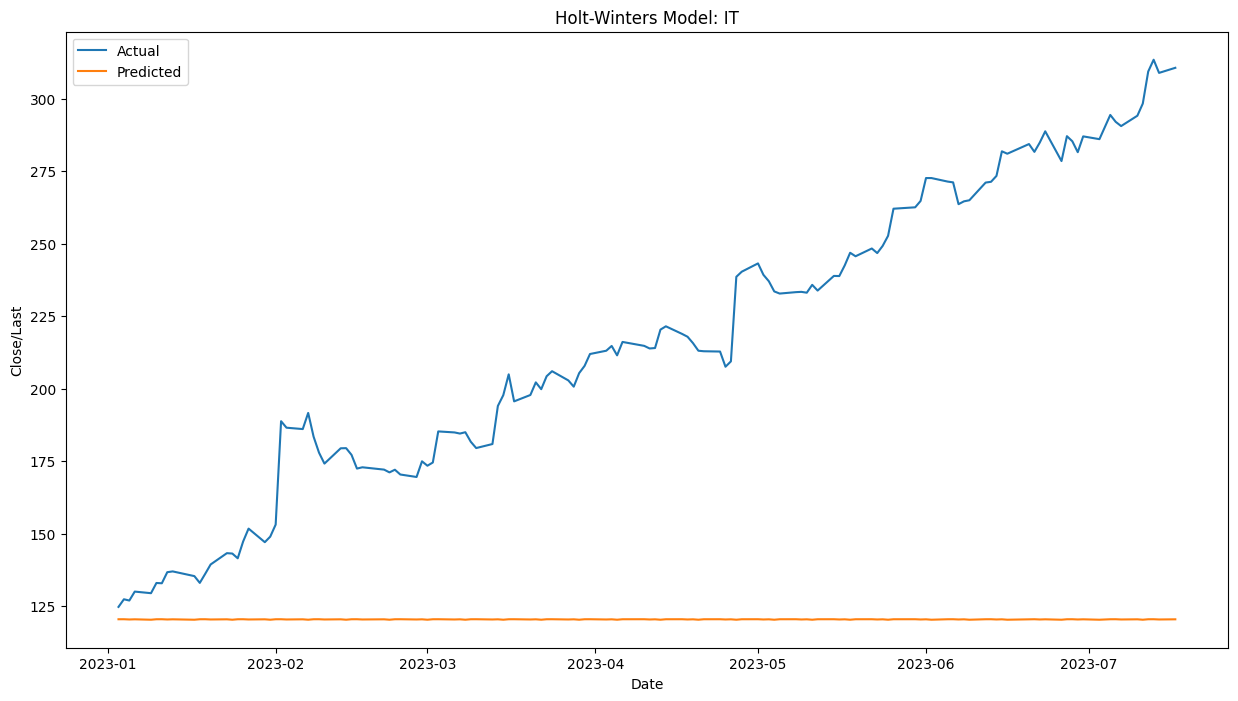

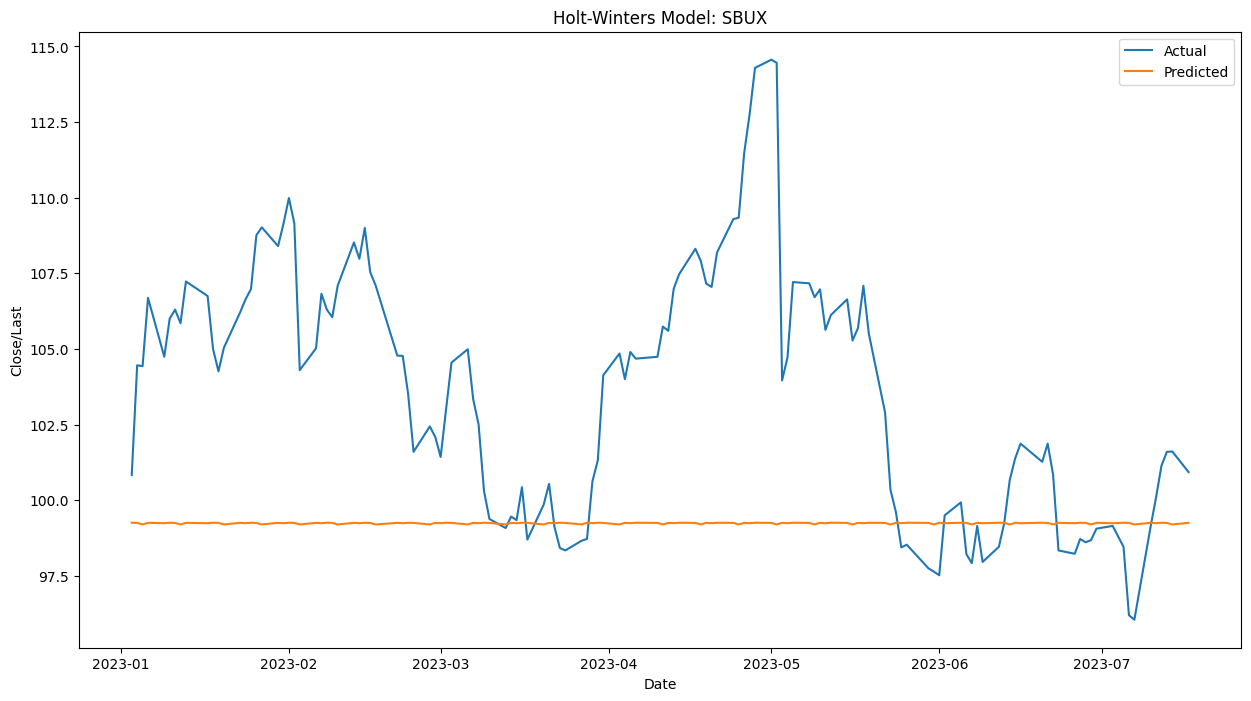

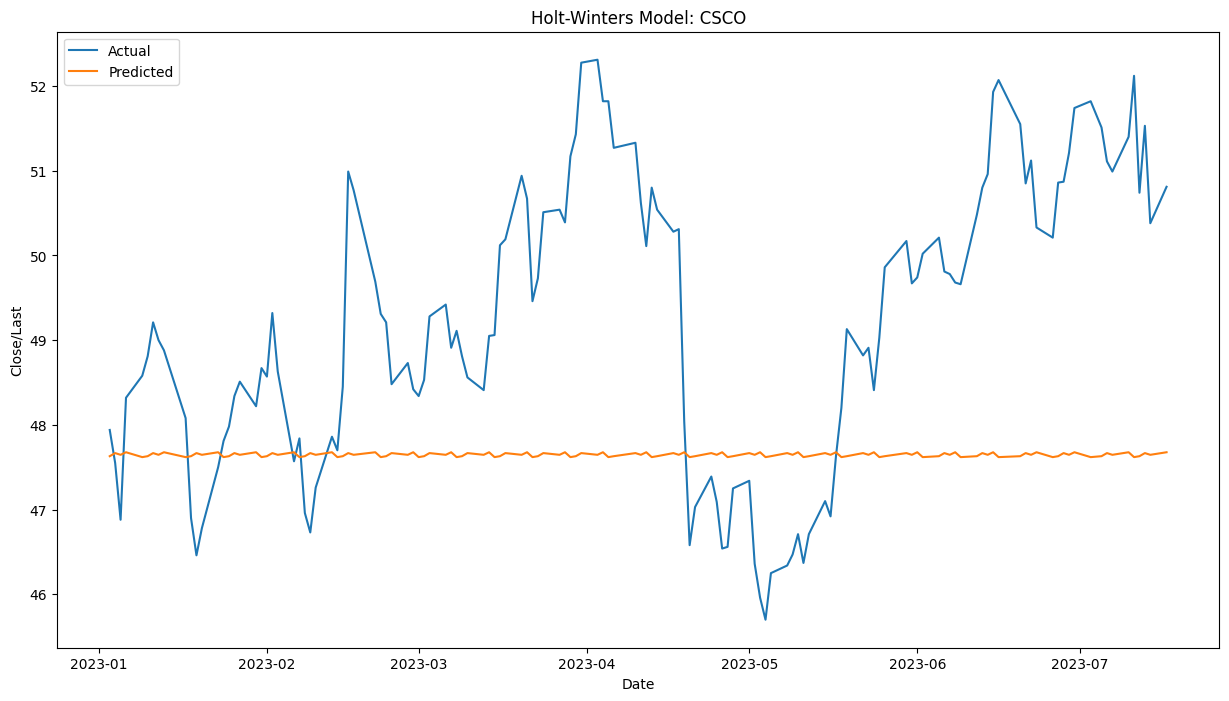

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0669
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.7633e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.8538e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.9071e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.3874e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.6895e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0512e-04
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.1011e-04
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.5759e-04
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.0952e-04
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6315e-04
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7035e-04
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8419e-04
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6379e-04
Epoch 15/20
75/75 

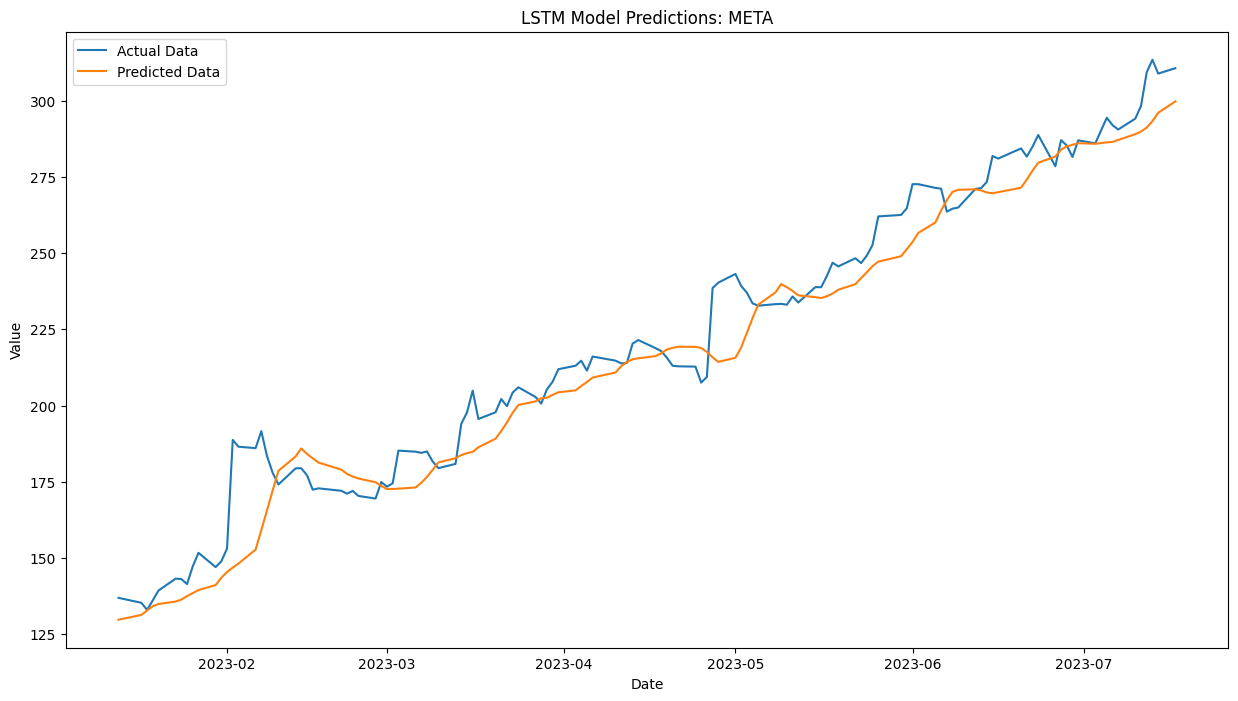

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0507
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8732e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.4579e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.7481e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.4026e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1265e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.4001e-04
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.0980e-04
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.0603e-04
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1178e-04
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.4249e-04
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8903e-04
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3595e-04
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7152e-04
Epoch 15/20
75/75 ━━

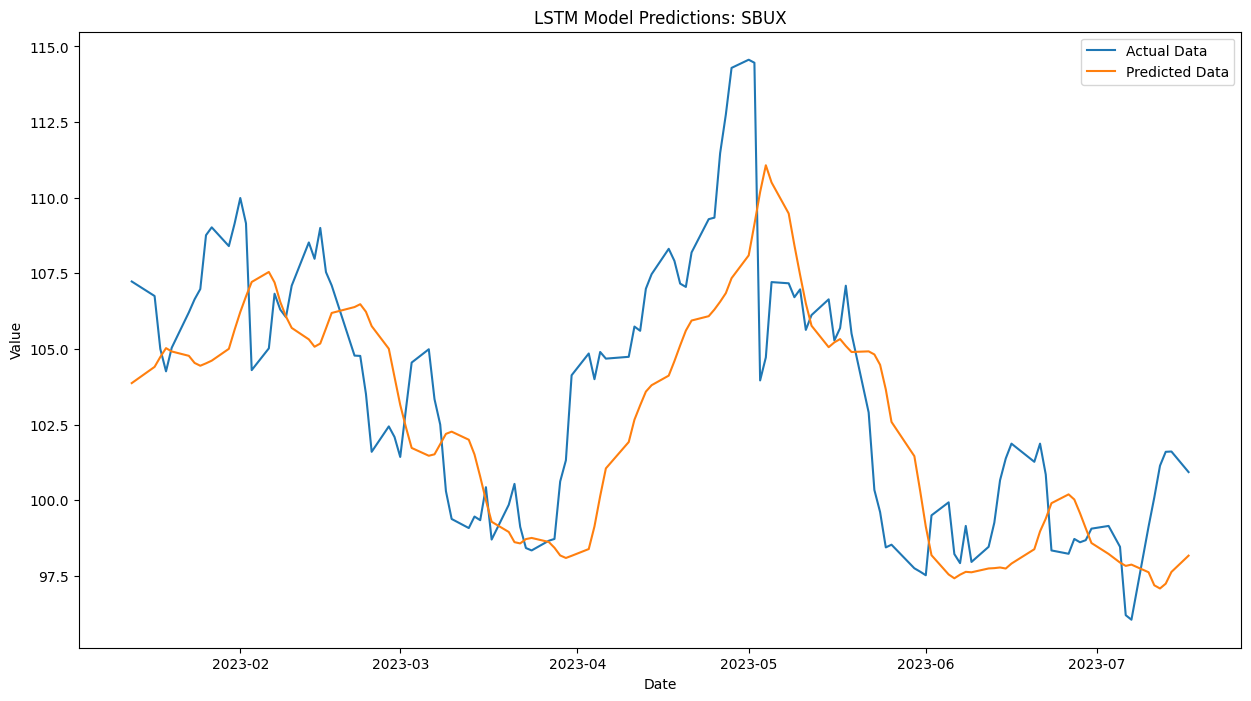

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0764
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.8749e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.5426e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.5545e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.9324e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.7597e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.0491e-04
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.8163e-04
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.1528e-04
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.8831e-04
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.3670e-04
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2039e-04
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.3053e-04
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.3159e-04
Epoch 15/20
75/75 ━━━━━━━━━━━━

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


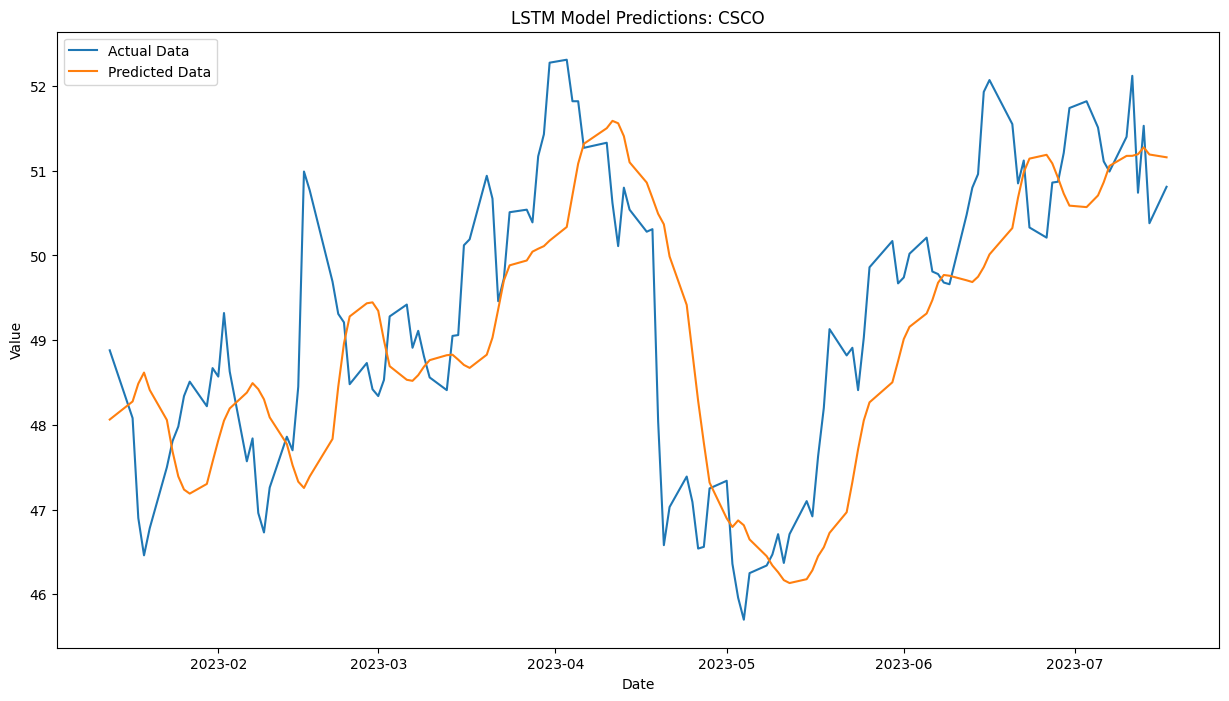

In [ ]:
# Create training / test sets

# TODO: create variables holding all training, validation, and testing data
# you'll use in the model building step
#drop columns that won't be used for this analysis
df_META_slim = df_META.drop(columns = ['Volume', 'Open', 'High', 'Low'])
df_SBUX_slim = df_SBUX.drop(columns = ['Volume', 'Open', 'High', 'Low'])
df_CSCO_slim = df_CSCO.drop(columns = ['Volume', 'Open', 'High', 'Low'])

#Train on data from 2013 to 2022 and test on 2023
df_META_train = df_META_slim[df_META_slim['Date'] < '2023-01-01']
df_META_test = df_META_slim[df_META_slim['Date']>='2023-01-01']
df_SBUX_train = df_SBUX_slim[df_SBUX_slim['Date'] < '2023-01-01']
df_SBUX_test = df_SBUX_slim[df_SBUX_slim['Date']>='2023-01-01']
df_CSCO_train = df_CSCO_slim[df_CSCO_slim['Date'] < '2023-01-01']
df_CSCO_test = df_CSCO_slim[df_CSCO_slim['Date']>='2023-01-01']
#sort dfs by date
df_META_train = df_META_train.sort_values(by='Date')
df_META_test = df_META_test.sort_values(by='Date')
df_CSCO_train = df_CSCO_train.sort_values(by='Date')
df_CSCO_test = df_CSCO_test.sort_values(by='Date')
df_SBUX_test = df_SBUX_test.sort_values(by='Date')
df_SBUX_train = df_SBUX_train.sort_values(by='Date')
# Model Building

# TODO: Train ML models over data from the prior step and prepare the model
# to be tested in the next step.

#Holt Winters

##META

holt_model_META = ExponentialSmoothing(df_META_train['Close/Last'],  seasonal='add', seasonal_periods=5)
holt_model_fit_META = holt_model_META.fit()
test_predictions_META = holt_model_fit_META.forecast(len(df_META_test))
train_predictions_META = holt_model_fit_META.forecast(len(df_META_train))

##SBUX
holt_model_SBUX = ExponentialSmoothing(df_SBUX_train['Close/Last'],  seasonal='add', seasonal_periods=5)
holt_model_fit_SBUX = holt_model_SBUX.fit()
test_predictions_SBUX = holt_model_fit_SBUX.forecast(len(df_SBUX_test))
train_predictions_SBUX = holt_model_fit_SBUX.forecast(len(df_SBUX_train))

##CSCO

holt_model_CSCO = ExponentialSmoothing(df_CSCO_train['Close/Last'],  seasonal='add', seasonal_periods=5)
holt_model_fit_CSCO = holt_model_CSCO.fit()
test_predictions_CSCO = holt_model_fit_CSCO.forecast(len(df_CSCO_test))
train_predictions_CSCO = holt_model_fit_CSCO.forecast(len(df_CSCO_train))

#plot the model v. the actual values from the test data set
plt.figure(figsize=(15, 8))
plt.plot(df_META_test['Date'], df_META_test['Close/Last'], label='Actual')
plt.plot(df_META_test['Date'], test_predictions_META, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close/Last')
plt.title('Holt-Winters Model: META')
plt.legend()
plt.show()

plt.figure(figsize=(15, 8))
plt.plot (df_SBUX_test['Date'], df_SBUX_test['Close/Last'], label='Actual')
plt.plot(df_SBUX_test['Date'], test_predictions_SBUX, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close/Last')
plt.title('Holt-Winters Model: SBUX')
plt.legend()
plt.show()

plt.figure(figsize=(15, 8))
plt.plot (df_CSCO_test['Date'], df_CSCO_test['Close/Last'], label='Actual')
plt.plot(df_CSCO_test['Date'], test_predictions_CSCO, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close/Last')
plt.title('Holt-Winters Model: CSCO')
plt.legend()
plt.show()


#LSTM

#Scale and prep data

scaler_META = MinMaxScaler()
scaler_SBUX = MinMaxScaler()
scaler_CSCO = MinMaxScaler()
df_META_train_LSTM = df_META_train.copy()
df_META_test_LSTM = df_META_test.copy()
df_META_train_LSTM['Close/Last'] = scaler_META.fit_transform(np.array((df_META_train_LSTM['Close/Last'])).reshape(-1,1))
df_META_test_LSTM['Close/Last'] = scaler_META.transform(np.array((df_META_test_LSTM['Close/Last'])).reshape(-1,1))
df_SBUX_train_LSTM = df_SBUX_train.copy()
df_SBUX_test_LSTM = df_SBUX_test.copy()
df_SBUX_train_LSTM['Close/Last'] = scaler_SBUX.fit_transform(np.array((df_SBUX_train_LSTM['Close/Last'])).reshape(-1,1))
df_SBUX_test_LSTM['Close/Last'] = scaler_SBUX.transform(np.array((df_SBUX_test_LSTM['Close/Last'])).reshape(-1,1))
df_CSCO_train_LSTM = df_CSCO_train.copy()
df_CSCO_test_LSTM = df_CSCO_test.copy()
df_CSCO_train_LSTM['Close/Last'] = scaler_CSCO.fit_transform(np.array((df_CSCO_train_LSTM['Close/Last'])).reshape(-1,1))
df_CSCO_test_LSTM['Close/Last'] = scaler_CSCO.transform(np.array((df_CSCO_test_LSTM['Close/Last'])).reshape(-1,1))

##META

# Create dataset function

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)
time_step = 7
X, y = create_dataset(df_META_train_LSTM['Close/Last'].values, time_step)
Xtest, ytest = create_dataset(df_META_test_LSTM['Close/Last'].values, time_step)
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=20, batch_size=32)
# Make predictions
predictions_META = model.predict(Xtest)
predictions_META = scaler_META.inverse_transform(predictions_META)

# Plot the results
plt.figure(figsize=(15, 8))
#plt.plot(df.index[time_step+1:], df['Value'][time_step+1:], label='Actual Data')
#plt.plot(df.index[time_step+1:], predictions, label='Predicted Data')
plt.plot(df_META_test['Date'][time_step+1:], df_META_test['Close/Last'][time_step+1:], label='Actual Data')
plt.plot(df_META_test['Date'][time_step+1:], predictions_META, label='Predicted Data')
plt.title('LSTM Model Predictions: META')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


##SBUX

X, y = create_dataset(df_SBUX_train_LSTM['Close/Last'].values, time_step)
Xtest, ytest = create_dataset(df_SBUX_test_LSTM['Close/Last'].values, time_step)
#Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

#Train model
model.fit(X, y, epochs=20, batch_size=32)
#Make predictions
predictions_SBUX = model.predict(Xtest)
predictions_SBUX = scaler_SBUX.inverse_transform(predictions_SBUX)

#Plot the results
plt.figure(figsize=(15, 8))
plt.plot(df_SBUX_test['Date'][time_step+1:], df_SBUX_test['Close/Last'][time_step+1:], label='Actual Data')
plt.plot(df_SBUX_test['Date'][time_step+1:], predictions_SBUX, label = 'Predicted Data')
plt.title('LSTM Model Predictions: SBUX')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

##CSCO

X, y = create_dataset(df_CSCO_train_LSTM['Close/Last'].values, time_step)
Xtest, ytest = create_dataset(df_CSCO_test_LSTM['Close/Last'].values, time_step)
#Build LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

#Train
model.fit(X, y, epochs=20, batch_size=32)
#Make predictions
predictions_CSCO = model.predict(Xtest)
predictions_CSCO = scaler_CSCO.inverse_transform(predictions_CSCO)

#Plot the results
plt.figure(figsize=(15, 8))
plt.plot(df_CSCO_test['Date'][time_step+1:], df_CSCO_test['Close/Last'][time_step+1:], label='Actual Data')
plt.plot(df_CSCO_test['Date'][time_step+1:], predictions_CSCO, label = 'Predicted Data')
plt.title('LSTM Model Predictions: CSCO')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


mse_test_META_LSTM = mean_squared_error(df_META_test['Close/Last'][time_step+1:], predictions_META)
rmse_test_META_LSTM = np.sqrt(mse_test_META_LSTM)
#mse_train_META_LSTM = mean_squared_error(df_META_train['Close/Last'], train_predictions_META)
#rmse_train_META_LSTM = np.sqrt(mse_train_META_Holt)
mse_test_SBUX_LSTM = mean_squared_error(df_SBUX_test_LSTM['Close/Last'][time_step+1:], predictions_SBUX)
rmse_test_SBUX_LSTM = np.sqrt(mse_test_SBUX_LSTM)
#mse_train_SBUX_LSTM = mean_squared_error(df_SBUX_train['Close/Last'], train_predictions_SBUX)
#rmse_train_SBUX_LSTM = np.sqrt(mse_train_SBUX_Holt)
mse_test_CSCO_LSTM = mean_squared_error(df_CSCO_test_LSTM['Close/Last'][time_step+1:], predictions_CSCO)
rmse_test_CSCO_LSTM = np.sqrt(mse_test_CSCO_LSTM)
#mse_train_CSCO_LSTM = mean_squared_error(df_CSCO_train['Close/Last'], train_predictions_CSCO)
#rmse_train_CSCO_LSTM = np.sqrt(mse_train_CSCO_Holt)






### ARIMA MODEL

'Date' column is already in datetime format. Skipping string replacement.
'Date' column is already in datetime format. Skipping string replacement.
'Date' column is already in datetime format. Skipping string replacement.
'Date' column is already in datetime format. Skipping string replacement.
'Date' column is already in datetime format. Skipping string replacement.
'Date' column is already in datetime format. Skipping string replacement.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

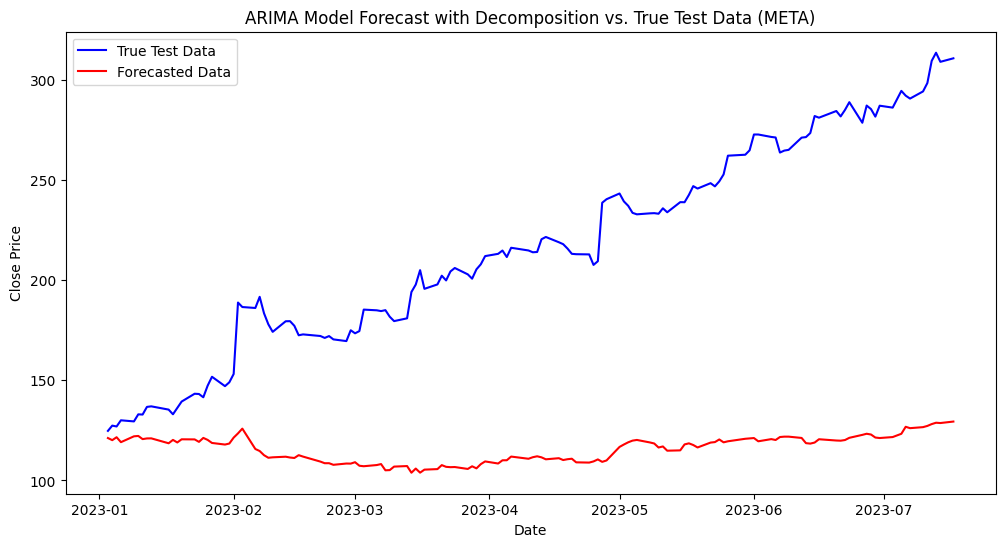

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

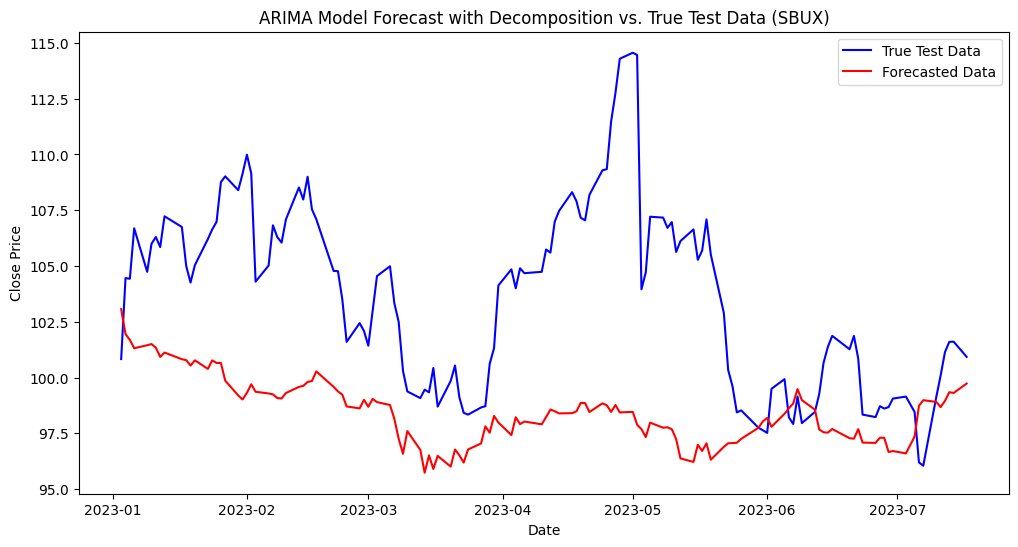

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

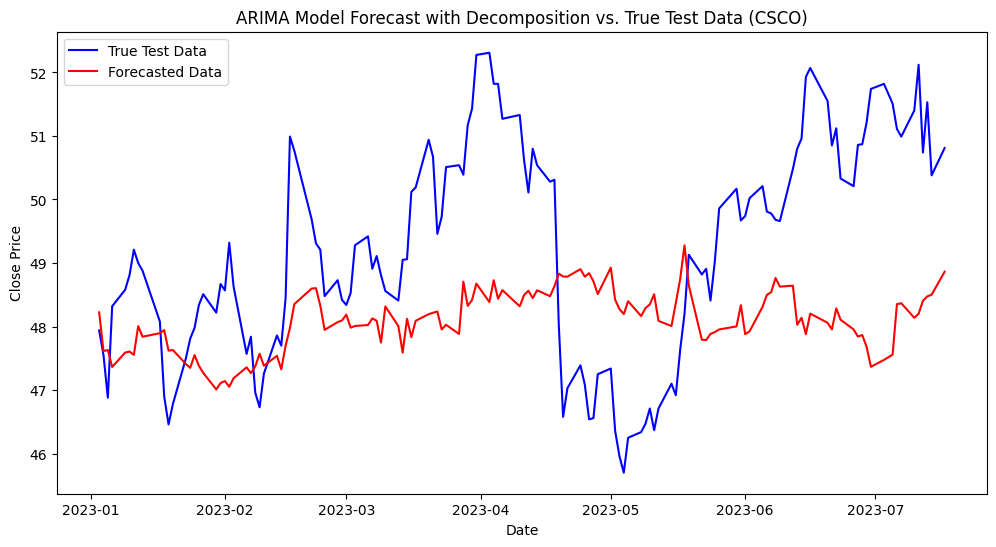

In [ ]:


#Preparing each data frame:
def clean_and_convert_date(df, date_column='Date'):
    """
    Cleans and converts the specified date column to datetime.
    Only applies string replacement if the column is of object type.
    """
    if date_column in df.columns:
        if df[date_column].dtype == 'object':
            # Replace '-' with '/' if present
            df[date_column] = df[date_column].str.replace('-', '/', regex=False)
            # Convert to datetime
            df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y', errors='coerce')
        elif pd.api.types.is_datetime64_any_dtype(df[date_column]):
            print(f"'{date_column}' column is already in datetime format. Skipping string replacement.")
        else:
            print(f"'{date_column}' column has an unsupported data type: {df[date_column].dtype}")
    else:
        print(f"'{date_column}' column is not in the DataFrame. It might already be set as index.")
    return df

def set_date_as_index(df, date_column='Date'):
    """
    Sets the specified date column as the index.
    Checks if the date column exists and if it's already the index.
    """
    if date_column in df.columns:
        df.set_index(date_column, inplace=True)
    elif df.index.name == date_column:
        print(f"'{date_column}' is already set as index.")
    else:
        print(f"'{date_column}' column not found in DataFrame.")
    return df

def prepare_dataframe(df, date_column='Date', currency_columns=['Close/Last', 'Open', 'High', 'Low']):
    """
    Prepares the DataFrame by cleaning and converting date and currency columns,
    and setting the date column as the index.
    """
    # Clean and convert date column
    df = clean_and_convert_date(df, date_column)

    # Set date as index
    df = set_date_as_index(df, date_column)

    return df

# Prepare META DataFrames
df_META_train = prepare_dataframe(df_META_train)
df_META_test = prepare_dataframe(df_META_test)

# Prepare SBUX DataFrames
df_SBUX_train = prepare_dataframe(df_SBUX_train)
df_SBUX_test = prepare_dataframe(df_SBUX_test)

# Prepare CSCO DataFrames
df_CSCO_train = prepare_dataframe(df_CSCO_train)
df_CSCO_test = prepare_dataframe(df_CSCO_test)



"META"

#Previously found optimal model order
model_order = (1, 1, 3)

# Fit the ARIMA model on the training data
arima_model_META = ARIMA(df_META_train['Close/Last'], order=model_order)
arima_META_result = arima_model_META.fit()

# ---------------------------
# In-Sample Predictions
# ---------------------------

# Generate in-sample predictions for the training data
in_sample_pred = arima_META_result.predict(start=df_META_train.index[0], end=df_META_train.index[-1])

# ---------------------------
# Forecasting
# ---------------------------

# Determine the number of steps to forecast (length of test data)
forecast_steps = len(df_META_test)

# Generate forecast for the test period
forecast_META = arima_META_result.get_forecast(steps=forecast_steps)

# Extract forecasted mean and confidence intervals
fc_META = forecast_META.predicted_mean
cnf_META = forecast_META.conf_int()

# Ensure the forecast index matches the test data index
fc_META.index = df_META_test.index
cnf_META.index = df_META_test.index

# ---------------------------
# Seasonal Decomposition
# ---------------------------

period = 252  #trading days in a year

# Decompose the training data
decomposition = seasonal_decompose(df_META_train['Close/Last'], model='additive', period=period)
seasonal = decomposition.seasonal

# Drop NaN values resulting from the decomposition
seasonal.dropna(inplace=True)

# Adjust 'df_META_train' to match the 'seasonal' index
df_META_train = df_META_train.loc[seasonal.index]

# ---------------------------
# Adjusting Forecast with Seasonal Component
# ---------------------------

# Extract the last 'period' values of the seasonal component to extend into the forecast period
seasonal_period = seasonal.iloc[-period:].values

# Create a seasonal forecast by repeating the seasonal pattern
seasonal_forecast = np.tile(seasonal_period, int(np.ceil(forecast_steps / period)))[:forecast_steps]
seasonal_forecast = pd.Series(seasonal_forecast, index=df_META_test.index)

# Ensure there are no NaN values in 'seasonal_forecast'
seasonal_forecast.dropna(inplace=True)

# ---------------------------
# Final Forecast Adjustments
# ---------------------------
final_forecast = fc_META + seasonal_forecast

# ---------------------------
# Plotting the Results
# ---------------------------

plt.figure(figsize=(12, 6))
plt.plot(df_META_test.index, df_META_test['Close/Last'], label='True Test Data', color='blue')
plt.plot(final_forecast.index, final_forecast, label='Forecasted Data', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Model Forecast with Decomposition vs. True Test Data (META)')
plt.legend()
plt.show()

"SBUX"

# ---------------------------
# Model Training
# ---------------------------

# Update the model order based on auto_arima results
model_order = (1, 1, 0)

# Fit the ARIMA model on the training data
arima_model_SBUX = ARIMA(df_SBUX_train['Close/Last'], order=model_order)
arima_SBUX_result = arima_model_SBUX.fit()

# ---------------------------
# In-Sample Predictions
# ---------------------------

# Generate in-sample predictions for the training data
in_sample_pred = arima_SBUX_result.predict(start=df_SBUX_train.index[0], end=df_SBUX_train.index[-1])

# ---------------------------
# Forecasting
# ---------------------------

# Determine the number of steps to forecast (length of test data)
forecast_steps = len(df_SBUX_test)

# Generate forecast for the test period
forecast_SBUX = arima_SBUX_result.get_forecast(steps=forecast_steps)
fc_SBUX = forecast_SBUX.predicted_mean
cnf_SBUX = forecast_SBUX.conf_int()
fc_SBUX.index = df_SBUX_test.index
cnf_SBUX.index = df_SBUX_test.index

# ---------------------------
# Seasonal Decomposition
# ---------------------------

# Perform seasonal decomposition on the training data to get the seasonal component
period = 252

# Decompose the training data
decomposition = seasonal_decompose(df_SBUX_train['Close/Last'], model='additive', period=period)
seasonal = decomposition.seasonal

# Drop NaN values resulting from the decomposition
seasonal.dropna(inplace=True)

# Adjust 'df_SBUX_train' to match the 'seasonal' index
df_SBUX_train = df_SBUX_train.loc[seasonal.index]

# ---------------------------
# Adjusting Forecast with Seasonal Component
# ---------------------------

# Extract the last 'period' values of the seasonal component to extend into the forecast period
seasonal_period = seasonal.iloc[-period:].values

# Create a seasonal forecast by repeating the seasonal pattern
seasonal_forecast = np.tile(seasonal_period, int(np.ceil(forecast_steps / period)))[:forecast_steps]
seasonal_forecast = pd.Series(seasonal_forecast, index=df_SBUX_test.index)

# Ensure there are no NaN values in 'seasonal_forecast'
seasonal_forecast.dropna(inplace=True)

# ---------------------------
# Final Forecast Adjustments
# ---------------------------

# Adjust the forecasted values by adding the seasonal component
final_forecast = fc_SBUX + seasonal_forecast

# ---------------------------
# Plotting the Results
# ---------------------------

plt.figure(figsize=(12, 6))
plt.plot(df_SBUX_test.index, df_SBUX_test['Close/Last'], label='True Test Data', color='blue')
plt.plot(final_forecast.index, final_forecast, label='Forecasted Data', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Model Forecast with Decomposition vs. True Test Data (SBUX)')
plt.legend()
plt.show()

"CSCO"

# Update the model order
model_order = (2,1,2)

# ---------------------------
# Model Training with Best Order
# ---------------------------

# Fit the ARIMA model on the training data with the best order
arima_model_CSCO = ARIMA(df_CSCO_train['Close/Last'], order=model_order)
arima_CSCO_result = arima_model_CSCO.fit()

# ---------------------------
# Forecasting
# ---------------------------

# Determine the number of steps to forecast (length of test data)
forecast_steps = len(df_CSCO_test)

# Generate forecast for the test period
forecast_CSCO = arima_CSCO_result.get_forecast(steps=forecast_steps)

# Extract forecasted mean and confidence intervals
fc_CSCO = forecast_CSCO.predicted_mean
cnf_CSCO = forecast_CSCO.conf_int()

# Ensure the forecast index matches the test data index
fc_CSCO.index = df_CSCO_test.index
cnf_CSCO.index = df_CSCO_test.index

# ---------------------------
# Seasonal Decomposition
# ---------------------------

# Perform seasonal decomposition on the training data to get the seasonal component
period = 252  # trading days in a year

# Decompose the training data
decomposition = seasonal_decompose(df_CSCO_train['Close/Last'], model='additive', period=period)
seasonal = decomposition.seasonal

# Drop NaN values resulting from the decomposition
seasonal.dropna(inplace=True)

# Adjust 'df_CSCO_train' to match the 'seasonal' index
df_CSCO_train = df_CSCO_train.loc[seasonal.index]

# ---------------------------
# Adjusting Forecast with Seasonal Component
# ---------------------------

# Extract the last 'period' values of the seasonal component to extend into the forecast period
seasonal_period = seasonal.iloc[-period:].values

# Create a seasonal forecast by repeating the seasonal pattern
seasonal_forecast = np.tile(seasonal_period, int(np.ceil(forecast_steps / period)))[:forecast_steps]
seasonal_forecast = pd.Series(seasonal_forecast, index=df_CSCO_test.index)

# Ensure there are no NaN values in 'seasonal_forecast'
seasonal_forecast.dropna(inplace=True)

# ---------------------------
# Final Forecast Adjustments
# ---------------------------

# Adjust the forecasted values by adding the seasonal component
final_forecast = fc_CSCO + seasonal_forecast

# ---------------------------
# Plotting the Results
# ---------------------------

plt.figure(figsize=(12, 6))
plt.plot(df_CSCO_test.index, df_CSCO_test['Close/Last'], label='True Test Data', color='blue')
plt.plot(final_forecast.index, final_forecast, label='Forecasted Data', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Model Forecast with Decomposition vs. True Test Data (CSCO)')
plt.legend()
plt.show()

### Simple RNN model


'Date' column is already in datetime format. Skipping string replacement.
'Date' column is already in datetime format. Skipping string replacement.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 7, 256)              │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 115,457 (451.00 KB)

 Trainable params: 115,457 (451.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.3002 - val_loss: 9.9906e-04
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0043 - val_loss: 8.2452e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0024 - val_loss: 5.8887e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0024 - val_loss: 6.6058e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0023 - val_loss: 5.3425e-04
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0019 - val_loss: 4.7619e-04
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0019 - val_loss: 6.8887e-04
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0019 - val_loss: 7.7691e-04
Epoch 12/20
75/75 ━━━━━━━━━━━━━

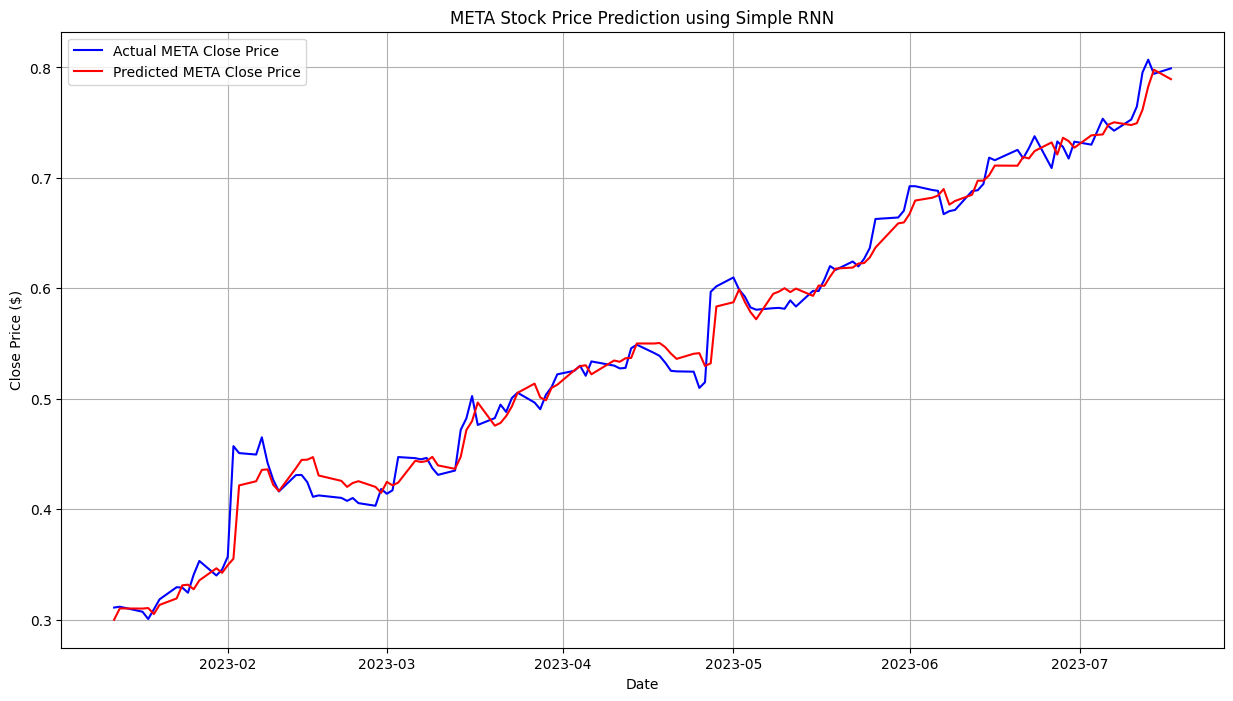

'Date' column is not in the DataFrame. It might already be set as index.
'Date' is already set as index.
'Date' column is already in datetime format. Skipping string replacement.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 7, 256)              │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 115,457 (451.00 KB)

 Trainable params: 115,457 (451.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.2393 - val_loss: 0.0022
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0037 - val_loss: 2.8498e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030 - val_loss: 2.9558e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0026 - val_loss: 1.4765e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026 - val_loss: 3.4935e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0030 - val_loss: 5.6501e-07
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0022 - val_loss: 2.5045e-06
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0021 - val_loss: 1.1033e-04
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018 - val_loss: 3.4220e-04
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018 - val_loss: 1.6733e-05
Epoch 12/20
75/75 ━━━━━━━━━

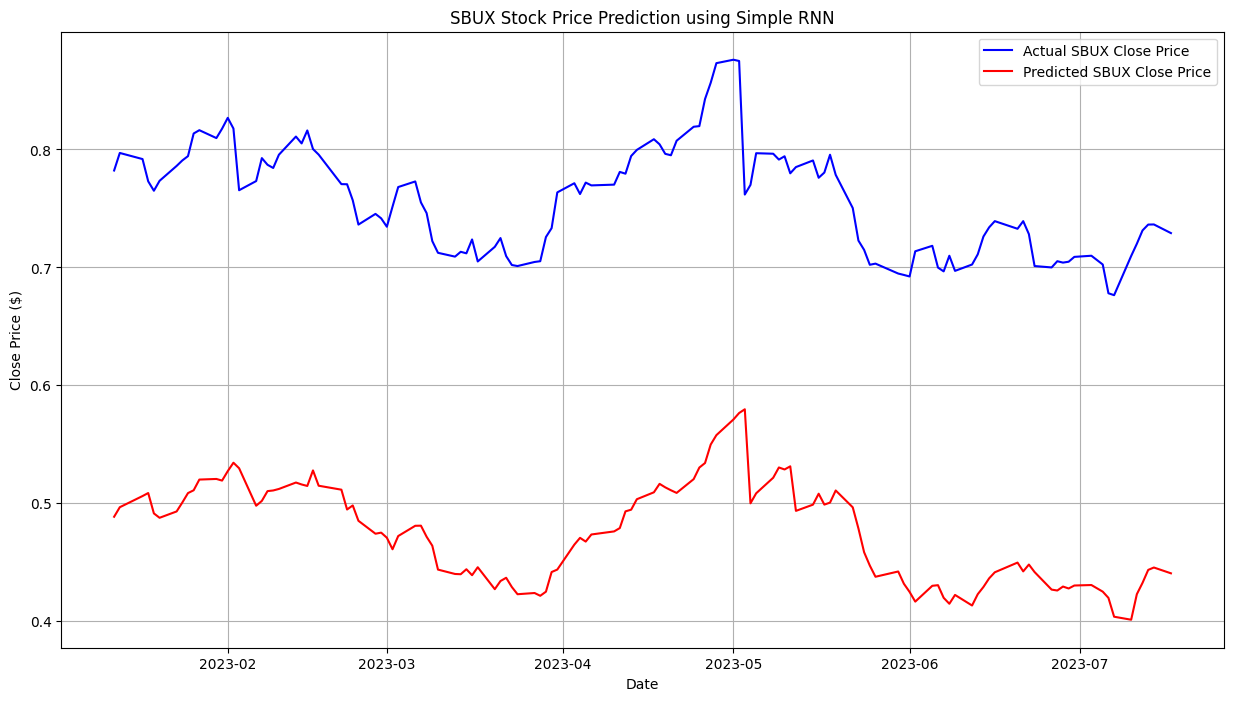

'Date' column is not in the DataFrame. It might already be set as index.
'Date' is already set as index.
'Date' column is already in datetime format. Skipping string replacement.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 7, 256)              │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 115,457 (451.00 KB)

 Trainable params: 115,457 (451.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2624 - val_loss: 0.0035
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0060 - val_loss: 4.5367e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0047 - val_loss: 3.8776e-06
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0039 - val_loss: 6.9364e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0041 - val_loss: 7.0897e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0028 - val_loss: 9.7277e-05
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0028 - val_loss: 1.6100e-04
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0025 - val_loss: 9.1703e-04
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0024 - val_loss: 5.4018e-06
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0024 - val_loss: 3.0259e-05
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0025 - val_loss: 9.3744e-05
Epoch 12/20
75/75 ━━━━━

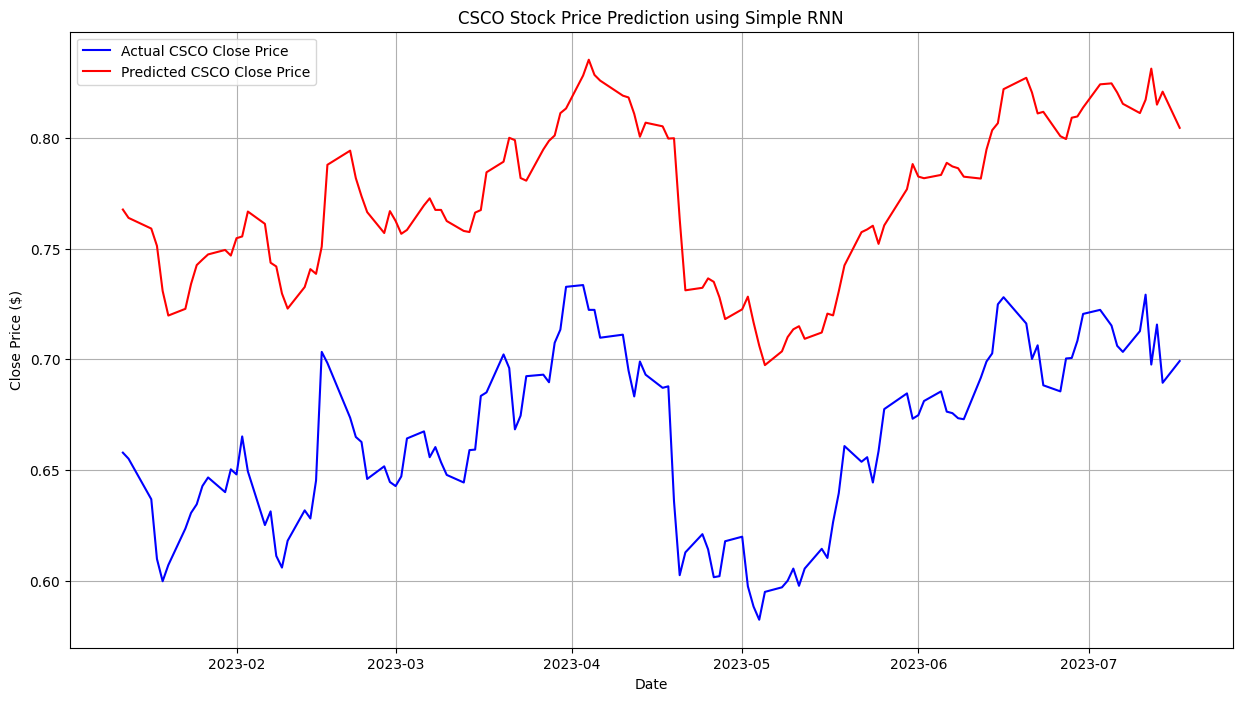

In [ ]:
# ---------------------- RNN Model for META ----------------------

def create_rnn_sequences_META(data, time_steps=7):
    """
    Creates input-output sequences for Simple RNN for META.

    Parameters:
    - data: Scaled 'Close/Last' data as a numpy array.
    - time_steps: Number of previous time steps to use for prediction.

    Returns:
    - X: Input sequences.
    - y: Corresponding target values.
    """
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps_RNN_META = 7

# Prepare the Data for META
# ----------------------------------------
df_META_train_RNN = df_META_train_LSTM.copy()
df_META_test_RNN = df_META_test_LSTM.copy()
scaler_META_RNN = MinMaxScaler(feature_range=(0, 1))
df_META_train_RNN['Close/Last'] = scaler_META_RNN.fit_transform(df_META_train_RNN[['Close/Last']])
df_META_test_RNN['Close/Last'] = scaler_META_RNN.transform(df_META_test_RNN[['Close/Last']])
df_META_train_RNN = prepare_dataframe(df_META_train_RNN)
df_META_test_RNN = prepare_dataframe(df_META_test_RNN)

# Create Sequences for META
# ----------------------------------------
train_data_RNN_META = df_META_train_RNN['Close/Last'].values.reshape(-1, 1)
test_data_RNN_META = df_META_test_RNN['Close/Last'].values.reshape(-1, 1)
X_train_RNN_META, y_train_RNN_META = create_rnn_sequences_META(train_data_RNN_META, time_steps_RNN_META)
X_test_RNN_META, y_test_RNN_META = create_rnn_sequences_META(test_data_RNN_META, time_steps_RNN_META)

# Reshape input to be [samples, time_steps, features] for META
X_train_RNN_META = X_train_RNN_META.reshape((X_train_RNN_META.shape[0], X_train_RNN_META.shape[1], 1))
X_test_RNN_META = X_test_RNN_META.reshape((X_test_RNN_META.shape[0], X_test_RNN_META.shape[1], 1))

# Build the Simple RNN Model for META
# ----------------------------------------
rnnmodel_META = Sequential()

# Add the first SimpleRNN layer
rnnmodel_META.add(SimpleRNN(
    units=256,
    activation='tanh',
    return_sequences=True,
    input_shape=(time_steps_RNN_META, 1)
))

# Add a Dropout layer to prevent overfitting
rnnmodel_META.add(Dropout(0.2))

# Add the second SimpleRNN layer
rnnmodel_META.add(SimpleRNN(
    units=128,
    activation='tanh'
))

# Add another Dropout layer
rnnmodel_META.add(Dropout(0.2))

# Add a Dense output layer
rnnmodel_META.add(Dense(1))

# Compile the model
rnnmodel_META.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

# Display the model's architecture
rnnmodel_META.summary()

# Train the Simple RNN Model for META
# ----------------------------------------
history_RNN_META = rnnmodel_META.fit(
    X_train_RNN_META, y_train_RNN_META,
    epochs=20,              # Number of training epochs
    batch_size=32,          # Number of samples per gradient update
    validation_data=(X_test_RNN_META, y_test_RNN_META),  # Validation data
    verbose=1               # Display progress bar
)

# Evaluate the Simple RNN Model for META
# ----------------------------------------
predictions_RNN_META = rnnmodel_META.predict(X_test_RNN_META)

# Inverse transform the scaled data back to original scale for META
predictions_RNN_META = scaler_META_RNN.inverse_transform(predictions_RNN_META)
y_test_actual_RNN_META = scaler_META_RNN.inverse_transform(y_test_RNN_META.reshape(-1, 1))

rmse_RNN_META = np.sqrt(mean_squared_error(y_test_actual_RNN_META, predictions_RNN_META))


# Visualize the Results for META
# ----------------------------------------
test_dates_RNN_META = df_META_test_RNN.index[time_steps_RNN_META:]

# Plot the actual vs predicted closing prices for META
plt.figure(figsize=(15, 8))
plt.plot(test_dates_RNN_META, y_test_actual_RNN_META, color='blue', label='Actual META Close Price')
plt.plot(test_dates_RNN_META, predictions_RNN_META, color='red', label='Predicted META Close Price')
plt.title('META Stock Price Prediction using Simple RNN')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()



# ---------------------- RNN Model for SBUX ----------------------

def create_rnn_sequences_SBUX(data, time_steps=7):
    """
    Creates input-output sequences for Simple RNN for SBUX.

    Parameters:
    - data: Scaled 'Close/Last' data as a numpy array.
    - time_steps: Number of previous time steps to use for prediction.

    Returns:
    - X: Input sequences.
    - y: Corresponding target values.
    """
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps_RNN_SBUX = 7

# Prepare the Data for SBUX
# ----------------------------------------
df_SBUX_train_RNN = df_SBUX_train.copy()
df_SBUX_test_RNN = df_SBUX_test_LSTM.copy()
scaler_SBUX_RNN = MinMaxScaler(feature_range=(0, 1))
df_SBUX_train_RNN['Close/Last'] = scaler_SBUX_RNN.fit_transform(df_SBUX_train_RNN[['Close/Last']])
df_SBUX_test_RNN['Close/Last'] = scaler_SBUX_RNN.transform(df_SBUX_test_RNN[['Close/Last']])
df_SBUX_train_RNN = prepare_dataframe(df_SBUX_train_RNN)
df_SBUX_test_RNN = prepare_dataframe(df_SBUX_test_RNN)

# Create Sequences for SBUX
# ----------------------------------------
train_data_RNN_SBUX = df_SBUX_train_RNN['Close/Last'].values.reshape(-1, 1)
test_data_RNN_SBUX = df_SBUX_test_RNN['Close/Last'].values.reshape(-1, 1)
X_train_RNN_SBUX, y_train_RNN_SBUX = create_rnn_sequences_SBUX(train_data_RNN_SBUX, time_steps_RNN_SBUX)
X_test_RNN_SBUX, y_test_RNN_SBUX = create_rnn_sequences_SBUX(test_data_RNN_SBUX, time_steps_RNN_SBUX)

# Reshape input to be [samples, time_steps, features] for SBUX
X_train_RNN_SBUX = X_train_RNN_SBUX.reshape((X_train_RNN_SBUX.shape[0], X_train_RNN_SBUX.shape[1], 1))
X_test_RNN_SBUX = X_test_RNN_SBUX.reshape((X_test_RNN_SBUX.shape[0], X_test_RNN_SBUX.shape[1], 1))

# Build the Simple RNN Model for SBUX
# ----------------------------------------
rnnmodel_SBUX = Sequential()

# Add the first SimpleRNN layer
rnnmodel_SBUX.add(SimpleRNN(
    units=256,
    activation='tanh',
    return_sequences=True,
    input_shape=(time_steps_RNN_SBUX, 1)
))

# Add a Dropout layer to prevent overfitting
rnnmodel_SBUX.add(Dropout(0.2))

# Add the second SimpleRNN layer
rnnmodel_SBUX.add(SimpleRNN(
    units=128,
    activation='tanh'
))

# Add another Dropout layer
rnnmodel_SBUX.add(Dropout(0.2))

# Add a Dense output layer
rnnmodel_SBUX.add(Dense(1))

# Compile the model
rnnmodel_SBUX.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

# Display the model's architecture
rnnmodel_SBUX.summary()

# Train the Simple RNN Model for SBUX
# ----------------------------------------
history_RNN_SBUX = rnnmodel_SBUX.fit(
    X_train_RNN_SBUX, y_train_RNN_SBUX,
    epochs=20,              # Number of training epochs
    batch_size=32,          # Number of samples per gradient update
    validation_data=(X_test_RNN_SBUX, y_test_RNN_SBUX),  # Validation data
    verbose=1               # Display progress bar
)

# Evaluate the Simple RNN Model for SBUX
# ----------------------------------------
predictions_RNN_SBUX = rnnmodel_SBUX.predict(X_test_RNN_SBUX)

# Inverse transform the scaled data back to original scale for SBUX
predictions_RNN_SBUX = scaler_SBUX_RNN.inverse_transform(predictions_RNN_SBUX)
y_test_actual_RNN_SBUX = scaler_SBUX_RNN.inverse_transform(y_test_RNN_SBUX.reshape(-1, 1))

rmse_RNN_SBUX = np.sqrt(mean_squared_error(y_test_actual_RNN_SBUX, predictions_RNN_SBUX))

# Visualize the Results for SBUX
# ----------------------------------------
test_dates_RNN_SBUX = df_SBUX_test_RNN.index[time_steps_RNN_SBUX:]

# Plot the actual vs predicted closing prices for SBUX
plt.figure(figsize=(15, 8))
plt.plot(test_dates_RNN_SBUX, y_test_actual_RNN_SBUX, color='blue', label='Actual SBUX Close Price')
plt.plot(test_dates_RNN_SBUX, predictions_RNN_SBUX, color='red', label='Predicted SBUX Close Price')
plt.title('SBUX Stock Price Prediction using Simple RNN')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()


# ---------------------- RNN Model for CSCO ----------------------

def create_rnn_sequences_CSCO(data, time_steps=7):
    """
    Creates input-output sequences for Simple RNN for CSCO.

    Parameters:
    - data: Scaled 'Close/Last' data as a numpy array.
    - time_steps: Number of previous time steps to use for prediction.

    Returns:
    - X: Input sequences.
    - y: Corresponding target values.
    """
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps_RNN_CSCO = 7

# Prepare the Data for CSCO
# ----------------------------------------
df_CSCO_train_RNN = df_CSCO_train.copy()
df_CSCO_test_RNN = df_CSCO_test_LSTM.copy()
scaler_CSCO_RNN = MinMaxScaler(feature_range=(0, 1))
df_CSCO_train_RNN['Close/Last'] = scaler_CSCO_RNN.fit_transform(df_CSCO_train_RNN[['Close/Last']])
df_CSCO_test_RNN['Close/Last'] = scaler_CSCO_RNN.transform(df_CSCO_test_RNN[['Close/Last']])
df_CSCO_train_RNN = prepare_dataframe(df_CSCO_train_RNN)
df_CSCO_test_RNN = prepare_dataframe(df_CSCO_test_RNN)

# Create Sequences for CSCO
# ----------------------------------------
train_data_RNN_CSCO = df_CSCO_train_RNN['Close/Last'].values.reshape(-1, 1)
test_data_RNN_CSCO = df_CSCO_test_RNN['Close/Last'].values.reshape(-1, 1)
X_train_RNN_CSCO, y_train_RNN_CSCO = create_rnn_sequences_CSCO(train_data_RNN_CSCO, time_steps_RNN_CSCO)
X_test_RNN_CSCO, y_test_RNN_CSCO = create_rnn_sequences_CSCO(test_data_RNN_CSCO, time_steps_RNN_CSCO)

# Reshape input to be [samples, time_steps, features] for CSCO
X_train_RNN_CSCO = X_train_RNN_CSCO.reshape((X_train_RNN_CSCO.shape[0], X_train_RNN_CSCO.shape[1], 1))
X_test_RNN_CSCO = X_test_RNN_CSCO.reshape((X_test_RNN_CSCO.shape[0], X_test_RNN_CSCO.shape[1], 1))

# Build the Simple RNN Model for CSCO
# ----------------------------------------
rnnmodel_CSCO = Sequential()

# Add the first SimpleRNN layer
rnnmodel_CSCO.add(SimpleRNN(
    units=256,
    activation='tanh',
    return_sequences=True,
    input_shape=(time_steps_RNN_CSCO, 1)
))

# Add a Dropout layer to prevent overfitting
rnnmodel_CSCO.add(Dropout(0.2))

# Add the second SimpleRNN layer
rnnmodel_CSCO.add(SimpleRNN(
    units=128,
    activation='tanh'
))

# Add another Dropout layer
rnnmodel_CSCO.add(Dropout(0.2))

# Add a Dense output layer
rnnmodel_CSCO.add(Dense(1))

# Compile the model
rnnmodel_CSCO.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

# Display the model's architecture
rnnmodel_CSCO.summary()

# Train the Simple RNN Model for CSCO
# ----------------------------------------
history_RNN_CSCO = rnnmodel_CSCO.fit(
    X_train_RNN_CSCO, y_train_RNN_CSCO,
    epochs=20,              # Number of training epochs
    batch_size=32,          # Number of samples per gradient update
    validation_data=(X_test_RNN_CSCO, y_test_RNN_CSCO),  # Validation data
    verbose=1               # Display progress bar
)

# Evaluate the Simple RNN Model for CSCO
# ----------------------------------------
predictions_RNN_CSCO = rnnmodel_CSCO.predict(X_test_RNN_CSCO)

# Inverse transform the scaled data back to original scale for CSCO
predictions_RNN_CSCO = scaler_CSCO_RNN.inverse_transform(predictions_RNN_CSCO)
y_test_actual_RNN_CSCO = scaler_CSCO_RNN.inverse_transform(y_test_RNN_CSCO.reshape(-1, 1))

rmse_RNN_CSCO = np.sqrt(mean_squared_error(y_test_actual_RNN_CSCO, predictions_RNN_CSCO))
# Visualize the Results for CSCO
# ----------------------------------------
test_dates_RNN_CSCO = df_CSCO_test_RNN.index[time_steps_RNN_CSCO:]

# Plot the actual vs predicted closing prices for CSCO
plt.figure(figsize=(15, 8))
plt.plot(test_dates_RNN_CSCO, y_test_actual_RNN_CSCO, color='blue', label='Actual CSCO Close Price')
plt.plot(test_dates_RNN_CSCO, predictions_RNN_CSCO, color='red', label='Predicted CSCO Close Price')
plt.title('CSCO Stock Price Prediction using Simple RNN')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()



### Model Testing

**TODO: (25-300 words) Explain any deviations from original testing plan or special circumstances you had to develop code to overcome for this phase.**
We used RMSE to test our models. The results are printed here.

In [ ]:
# Model Testing
mse_test_META_Holt = mean_squared_error(df_META_test['Close/Last'], test_predictions_META)
rmse_test_META_Holt = np.sqrt(mse_test_META_Holt)
mse_train_META_Holt = mean_squared_error(df_META_train['Close/Last'], train_predictions_META)
rmse_train_META_Holt = np.sqrt(mse_train_META_Holt)
mse_test_SBUX_Holt = mean_squared_error(df_SBUX_test['Close/Last'], test_predictions_SBUX)
rmse_test_SBUX_Holt = np.sqrt(mse_test_SBUX_Holt)
mse_train_SBUX_Holt = mean_squared_error(df_SBUX_train['Close/Last'], train_predictions_SBUX)
rmse_train_SBUX_Holt = np.sqrt(mse_train_SBUX_Holt)
mse_test_CSCO_Holt = mean_squared_error(df_CSCO_test['Close/Last'], test_predictions_CSCO)
rmse_test_CSCO_Holt = np.sqrt(mse_test_CSCO_Holt)
mse_train_CSCO_Holt = mean_squared_error(df_CSCO_train['Close/Last'], train_predictions_CSCO)
rmse_train_CSCO_Holt = np.sqrt(mse_train_CSCO_Holt)

print(f"RMSE for CSCO Holts-Winters: {rmse_test_CSCO_Holt:.2f}\n")
print(f"RMSE for META Holts-Winters: {rmse_test_META_Holt:.2f}\n")
print(f"RMSE for SBUX Holts-Winters: {rmse_test_SBUX_Holt:.2f}\n")

mse_test_META_LSTM = mean_squared_error(df_META_test['Close/Last'][time_step+1:], predictions_META)
rmse_test_META_LSTM = np.sqrt(mse_test_META_LSTM)
#mse_train_META_LSTM = mean_squared_error(df_META_train['Close/Last'], train_predictions_META)
#rmse_train_META_LSTM = np.sqrt(mse_train_META_Holt)
mse_test_SBUX_LSTM = mean_squared_error(df_SBUX_test_LSTM['Close/Last'][time_step+1:], predictions_SBUX)
rmse_test_SBUX_LSTM = np.sqrt(mse_test_SBUX_LSTM)
#mse_train_SBUX_LSTM = mean_squared_error(df_SBUX_train['Close/Last'], train_predictions_SBUX)
#rmse_train_SBUX_LSTM = np.sqrt(mse_train_SBUX_Holt)
mse_test_CSCO_LSTM = mean_squared_error(df_CSCO_test_LSTM['Close/Last'][time_step+1:], predictions_CSCO)
rmse_test_CSCO_LSTM = np.sqrt(mse_test_CSCO_LSTM)
#mse_train_CSCO_LSTM = mean_squared_error(df_CSCO_train['Close/Last'], train_predictions_CSCO)
#rmse_train_CSCO_LSTM = np.sqrt(mse_train_CSCO_Holt)



print(f"RMSE for CSCO LSTM: {rmse_test_CSCO_LSTM:.2f}\n\n")
print(f"RMSE for META LSTM: {rmse_test_META_LSTM:.2f}\n")
print(f"RMSE for SBUX LSTM: {rmse_test_SBUX_LSTM:.2f}\n")
# Implement the testing plan explained two sections ago

#ARIMA Model Evaluation

"CSCO"
final_forecast = fc_CSCO + seasonal_forecast
rmse=np.sqrt(mean_squared_error(df_CSCO_test['Close/Last'], final_forecast))
print(f"RMSE for CSCO ARIMA: {rmse:.2f}\n")

"META"
final_forecast = fc_META + seasonal_forecast
rmse=np.sqrt(mean_squared_error(df_META_test['Close/Last'], final_forecast))
print(f"RMSE for META ARIMA: {rmse:.2f}\n")

"SBUX"
final_forecast = fc_SBUX + seasonal_forecast
rmse=np.sqrt(mean_squared_error(df_SBUX_test['Close/Last'], final_forecast))
print(f"RMSE for SBUX ARIMA: {rmse:.2f}\n")

#RNN model evaluation
"CSCO"
print(f"RMSE for CSCO Simple RNN: {rmse_RNN_CSCO:.2f}")

"META"
print(f"RMSE for META Simple RNN: {rmse_RNN_META:.2f}\n")

"SBUX"
print(f"(RMSE for SBUX Simple RNN: {rmse_RNN_SBUX:.2f}\n")







RMSE for CSCO Holts-Winters: 2.28

RMSE for META Holts-Winters: 107.47

RMSE for SBUX Holts-Winters: 5.99

RMSE for META LSTM: 16.21

RMSE for SBUX LSTM: 103.47

RMSE for CSCO LSTM: 48.92


Meta ARIMA Model RMSE: 107.41

SBUX ARIMA Model RMSE: 5.71

CSCO ARIMA Model RMSE: 2.01



Root Mean Squared Error (RMSE) for Simple RNN - META: 0.02

Root Mean Squared Error (RMSE) for Simple RNN - SBUX: 0.28

Root Mean Squared Error (RMSE) for Simple RNN - CSCO: 0.11


## Results

**TODO: (200 - 600 words) Explain the signifigance and meaning of the results from the model testing phase. This may be a more or equally important place to include visualizations as the exploration step was.**
Our test rmses are significantly higher than those from the original study. Most of theirs were under 1, while some of ours were over 100. There are several possible explanations. One is that the data from COVID made it harder for the model to make predictions. Another explanation is that our data was different than the original data, so their might have been better suited for the models chosen. A third possible explanation is that our code is different. Their code was not included in their paper, so we had to use the written explanation of how they built the models, so they might have done more to perfect the models that they didn't include in their written explanation.
In general, the LSTM model seemed to preform the best out of all the models. The visualizations included in the model building section illustrate this.

In [ ]:
# Results

# Evaluate and visualize results from model testing.

## Conclusions / Lessons Learned

**TODO: (500 - 1000 words) Explain how your results answered the research question and how your answer compared to that of the original research. Pass judgement on the original research, using your experiment as evidence, on whether that researh provided accurate or important results.**
We started by collecting stock data from NASDAQ using webscrpaing. We then cleaned the data and edited it so that it would be usable for our purposes. From this data, which originally included data for 10 companies, we selected 3 to focus our research on. We used the Holt-Winters model, LSTM model, ARIMA model, and RNN model to model stock prices for Cisco System (CSCO), Starbucks (SBUX), and Meta  Platforms (META). We compared CSCO and META to the IT results from the original study, and we used SBUX to extend on the original results since they only looked at IT, Health, and Banking data. We simplified our project by not building MARS or Random Forest models.

With this project, we were looking to answer several questions. These include: "Are different types of models more suitable for modeling stock price data from different companies?" "Will training data from COVID make predictions less accurate?" and "Are our results (specifically the rmses) comparable to those found in the original research?"

Question 1 (Are different types of models more suitable for modeling stock price data from different companies?):

Based on the rmses, we found that the RNN model worked the best for all three companies. This differs from the original research becuase they found the ARIMA worked best for the IT sector. Similar to the original research, we found that the Holt-Winters model was generally a poor predictor of stock prices.

Question 2 (Will training data from COVID make predictions less accurate?):

Our rmses were larger than those found in the paper, which could be as a result of using data from COVID to train our models. Many of their models seemed to almost perfectly predict the stock prices for the test data, but we found that some of our graphs perdicted the general shape of the data, while the Holt-Winters model was nearly a horizontal line for all the companies we looked at.

Question 3 (Are our results comparable to those found in the original research?):

We found that our rmses were significantly higher than those in the original paper. We are suspicious of the results shown in the paper for several reasons. Firstly, several of their testing errors are lower than their training error, which seems unlikely as the expected value of test error is greater than or equal to the training error. Another potential issue with their results is that they report very small, very similar errors for the different models. One example where this seems suspicious is with the Holt-Winters model. Based on their graphs, the Holt-Winters model is a very poor fit for the data, but their test rmse is only .142. Since the paper didn't include code, we relied on their written explanation of their process, so it is possible that we misinterpreted part of their process when building and testing our models.

Both the original paper and our research suggest that ARIMA, LSTM, and RNN are decent models for predicting stock prices while to Holt Winters is not.